# Big Data FC

The goal of the **Big Data FC** project is to **predict** how many **points** a **football team** belonging to the main European football leagues will end the season with, according to the **characteristics of its players**.

To reach the goal, data relative to the **football players** will first be loaded, in order to then compose the **football teams**.
After that, a second dataset will be used to gather seasonal **rankings**, for every football team.

The project as a whole is composed of:

* This **notebook**, containing all steps of:
  * Data loading.
  * Data cleaning and pre-processing
  * Data visualization.
  * Data analysis.
  * Learning and evaluation.
* A custom [**scraper**](https://github.com/Big-Data-FC/scraper), to gather further players data.
* A set of **REST APIs** to query the loaded data and the prediction model.
* The collection of [scraped datasets](https://github.com/Big-Data-FC/datasets).

During the project, multiple approaches and techniques were explored, all described in this notebook.

_By [Daniele Solombrino](https://github.com/dansolombrino) and [Davide Quaranta](https://github.com/fortym2)._

# Notebook configuration, global parameters and utility functions

[state that we trained the models]

In [1]:
MAX_K_CLUSTERS = 66
MAX_ITER = 20

k_range = range(2, MAX_K_CLUSTERS, 4)
K_RANGE = [str(k) for k in k_range]

In [2]:
ADD_RP_TRADEOFF = [0.5, 1, 2, 4, 8]

In [3]:
attempts = range(1, 5)

TRAINED_MODELS_DIRS = {
    "Attempt " + str(k) : {
        "Regression": {
            "Linear Regression": f"trained_models/attempt_{k}/regression/linear_regression",
            "Prediction Tree": f"trained_models/attempt_{k}/regression/prediction_tree",
            "Gradient Boosted Tree": f"trained_models/attempt_{k}/regression/gradient_boosted_tree",
            "Random Forest": f"trained_models/attempt_{k}/regression/random_forest",
        },
        "Classification": {
            "SVM": f"trained_models/attempt_{k}/classification/svm",
            "Decision Tree": f"trained_models/attempt_{k}/classification/decision_tree",
            "Logistic Regression": f"trained_models/attempt_{k}/classification/logistic_regression",
            "Random Forest": f"trained_models/attempt_{k}/classification/random_forest",
            "MLP": f"trained_models/attempt_{k}/classification/mlp",
        }
    } for k in attempts
}

TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression multiple k"] = {
    k : f"trained_models/attempt_3/regression/linear_regression_multiple_k/{k}_clusters" for k in K_RANGE
}

TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression multiple tradeoffs"] = {
    tradeoff : f"trained_models/attempt_4/regression/linear_regression_multiple_tradeoffs/tradeoff_{tradeoff}" for tradeoff in ADD_RP_TRADEOFF
}


In [4]:
def model_exists(model_path):
    return os.path.isdir(model_path)

In [5]:
def load_model_from_disk(model_type, model_path):
    return model_type.load(model_path)

Before getting started, a series of components that are used across the entire project are imported.

In [6]:
#  PySpark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

import gc

import builtins
import operator
import json

import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
%matplotlib widget

import pandas as pd
import numpy as np

from functools import reduce

import pprint

In [7]:
conf = (
    SparkConf()
    .set("spark.ui.port", "4050")
    .set("spark.executor.memory", "4G")
    .set("spark.driver.memory", "20G")
    .set("spark.driver.maxResultSize", "10G")
)
# .set("spark.master", "spark://192.168.1.189:4050")


# create the context
sc = SparkContext(conf=conf)
sc.setLogLevel("ERROR")


spark = SparkSession.builder.getOrCreate()

22/06/26 11:30:09 WARN Utils: Your hostname, RTX-2070-Rig resolves to a loopback address: 127.0.1.1; using 192.168.1.189 instead (on interface wlp7s0)
22/06/26 11:30:09 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/06/26 11:30:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [8]:
import random 

random_seed = random.randint(0, sys.maxsize)

In [9]:
def plot_feature_target_relation(
    data, x, y, n_cols = 2, figsize = (15, 30), color = "#000000"
):

    n_rows = int(len(x) / n_cols) if len(x) >= n_cols else n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for x_ind, x_value in enumerate(x):
        ax = sns.regplot(
            data=data,
            x=x_value,
            y=y,
            color = color,
            ax=axes[x_ind // n_cols, x_ind % n_cols] if n_rows > 1 else axes,
        )


    fig.tight_layout()

In [10]:
def plot_feature_distribution(
    data,
    features,
    figsize=(4,4), 
    color="#000000",
    n_cols=2
):

    n_rows = int(len(features) / n_cols) if len(features) >= n_cols else n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

    for feature_ind, feature in enumerate(features):
        _ = sns.histplot(
            data[feature],
            kde=True,
            color=color,
            facecolor=color,
            ax=axes[feature_ind // n_cols, feature_ind % n_cols] if n_rows > 1 else axes,
        )

    fig.tight_layout(pad=1.5)

In [11]:
def plot_correlation_matrix(
    data, features, title="Pearson Correlation Matrix", figsize=(16,12)
):

    mask = np.zeros_like(data[features].corr(), dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    with sns.axes_style("white"):  # Temporarily set the background to white
        fig, ax = plt.subplots(figsize=figsize)
        plt.title(title, fontsize=24)

        cmap = sns.diverging_palette(220, 10, as_cmap=True)

        _ = sns.heatmap(
            data[features].corr(),
            linewidths=0.25,
            vmax=0.7,
            square=True,
            ax=ax,
            cmap=cmap,
            linecolor="w",
            annot=True,
            annot_kws={"size": 8},
            mask=mask,
            cbar_kws={"shrink": 0.9},
        )

In [12]:
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.regression import Regressor
from pyspark.ml.regression import LinearRegression, LinearRegressionModel, LinearRegressionTrainingSummary
from pyspark.ml.regression import RandomForestRegressor, RandomForestRegressionModel
from pyspark.ml.classification import Classifier
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import RandomForestClassificationTrainingSummary
from pyspark.ml.classification import MultilayerPerceptronClassificationSummary

from pyspark.ml.regression import RegressionModel
from pyspark.ml.classification import ClassificationModel
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

In [13]:
def get_evaluators(estimator, label_col, prediction_col, evaluation_metrics):
    evaluators = dict()

    if isinstance(estimator, Regressor) or isinstance(estimator, RegressionModel):
        evaluators = {
            metric: RegressionEvaluator(
                labelCol=label_col,
                predictionCol=prediction_col,
                metricName=metric,
            )
            for metric in evaluation_metrics
        }
    elif isinstance(
        estimator, Classifier
        ) or isinstance(estimator, OneVsRestModel) or isinstance(
            estimator, ClassificationModel
        ):
        evaluators = {
            metric: MulticlassClassificationEvaluator(
                labelCol=label_col,
                predictionCol=prediction_col,
                metricName=metric,
            )
            for metric in evaluation_metrics
        }
    else:
        raise Exception("Unexpected estimator, got" + str(type(estimator)))

    return evaluators


In [14]:
def learn_best_model(
    estimator, 
    param_grid,
    evaluator_cv
):
    cross_validator = CrossValidator(
        estimator=estimator,
        estimatorParamMaps=param_grid,
        evaluator=evaluator_cv,
        numFolds=5,
        collectSubModels=False
    )
    
    cross_validated_model = cross_validator.fit(train_df)

    return cross_validated_model

In [15]:
def evaluate_learning_models(
    best_model, 
    evaluators,
    save_training_result_path=None
):
    has_summary = True
    
    out_dict = {
        "train_set_evaluation": dict(),
        "test_set_evaluation": dict()
    }

    try:
        has_summary = best_model.hasSummary
    except AttributeError as e:
        # since the only models that have summary
        # have the hasSummary field,
        # it is needed to catch this exception
        has_summary = False
    
    if has_summary:
        print("Summary available, retrieving data...")

        if isinstance(
            best_model, LinearRegressionModel
        ) or isinstance(best_model, RandomForestClassificationModel):
            training_result = best_model.summary
        elif isinstance(best_model, MultilayerPerceptronClassificationModel):
            training_result = best_model.summary()
        
        print("-----------------------------")
        print(training_result.r2)
        print("-----------------------------")


        if any(
            x in type(best_model).__name__ for x in [
                "LinearRegression", 
                "DecisionTreeRegressor", 
                "GBTRegressor",
                "RandomForestRegressor"
            ]
        ):
            out_dict["train_set_evaluation"]["r2"] = training_result.r2
            out_dict["train_set_evaluation"]["r2adj"] = training_result.r2adj
            out_dict["train_set_evaluation"]["meanSquaredError"] = training_result.meanSquaredError
            out_dict["train_set_evaluation"]["meanAbsoluteError"] = training_result.meanAbsoluteError
            out_dict["train_set_evaluation"]["rootMeanSquaredError"] = training_result.rootMeanSquaredError
            out_dict["train_set_evaluation"]["explainedVariance"] = training_result.explainedVariance
        else:
            out_dict["train_set_evaluation"]["accuracy"] = training_result.accuracy
            out_dict["train_set_evaluation"]["falsePositiveRateByLabel"] = training_result.falsePositiveRateByLabel
            out_dict["train_set_evaluation"]["precisionByLabel"] = training_result.precisionByLabel
            out_dict["train_set_evaluation"]["recallByLabel"] = training_result.recallByLabel
            out_dict["train_set_evaluation"]["truePositiveRateByLabel"] = training_result.truePositiveRateByLabel
            out_dict["train_set_evaluation"]["weightedFalsePositiveRate"] = training_result.weightedFalsePositiveRate
            out_dict["train_set_evaluation"]["weightedPrecision"] = training_result.weightedPrecision
            out_dict["train_set_evaluation"]["weightedRecall"] = training_result.weightedRecall
            out_dict["train_set_evaluation"]["weightedTruePositiveRate"] = training_result.weightedTruePositiveRate
            out_dict["train_set_evaluation"]["fMeasureByLabel"] = training_result.fMeasureByLabel()
            out_dict["train_set_evaluation"]["weightedFMeasure"] = training_result.weightedFMeasure()

        predictions = best_model.transform(test_df)
                    
        for e, evaluator in evaluators.items():
            if save_training_result_path is not None:
                out_dict["test_set_evaluation"][evaluator.getMetricName()] = evaluator.evaluate(predictions)
    
    else: # no summary available
        print("No summary available, using custom evaluation procedure...")
        for stage_name, stage_df in zip(["Train", "Test"], [train_df, test_df]):
            predictions = best_model.transform(stage_df)

            for e, evaluator in evaluators.items():
                if save_training_result_path is not None:
                    out_dict[f"{stage_name.lower()}_set_evaluation"][evaluator.getMetricName()] = evaluator.evaluate(predictions)

    if save_training_result_path is not None:
        os.makedirs(
            os.path.join(
                *save_training_result_path.split("/")[:-1]
            ), 
            exist_ok=True
        ) 
        
        with open(save_training_result_path, "w", encoding="utf8") as f:
            f.write(json.dumps(out_dict))
    
    pprint.pprint(out_dict)

    return out_dict



In [16]:
import json

def print_model_evaluation(model_evaluation_path):
    
    with open(model_evaluation_path) as json_file:
        model_evaluation = json.load(json_file)
        
        pprint.pprint(model_evaluation)
        return model_evaluation

In [17]:
from pyspark.ml.feature import PCA

PCA_NUM_COMPONENTS = 2

def perform_pca(df, num_components, input_col, output_col):
    pca = PCA(
        k=num_components, 
        inputCol=input_col, 
        outputCol=output_col
    )
    pca_model = pca.fit(df)

    return pca_model.transform(df), pca_model

In [18]:
def plot_pca_explained_variance(pca_model, num_components_to_plot=2, figsize=(8,6)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    _ = sns.barplot(
        x=[i for i in range(num_components_to_plot)],
        y=pca_model.explainedVariance.values[0:num_components_to_plot],
        ax=ax,
        palette="summer"
    )

    _ = ax.set_xlabel("Eigenvalues", labelpad=16, fontsize=16)
    _ = ax.set_ylabel("Proportion of Variance", fontsize=16)
    _ = ax.set_xticklabels(
        [f"Principal Component {i}" for i in range(num_components_to_plot)], 
        rotation=0
    )
    _ = ax.set_title("Explained variance of each Principal Component")

In [19]:
def scatter_plot(
    x,
    y,
    x_label,
    y_label,
    title="",
    c=None,
    c_map=plt.cm.get_cmap("tab10"),
    figsize=(12,8),
    ):
    
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    _ = plt.scatter(
        x=x,
        y=y,
        c=y if c is None else c,
        edgecolor="none",
        #alpha=1,
        cmap=c_map,
        axes=ax,
    )

    _ = ax.set_xlabel(x_label, labelpad=20, fontsize=16)
    _ = ax.set_ylabel(y_label, fontsize=16)
    _ = ax.set_title(title)

    plt.colorbar()
    plt.show()

In [20]:
REGRESSION_EVALUATION_METRICS = ["r2", "mse", "rmse", "mae", "var"]
REGRESSION_EVALUATION_METRIC_CV = "r2"

REGRESSION_LABEL_COL = "points"

regression_evaluator_cv = RegressionEvaluator(
    metricName=REGRESSION_EVALUATION_METRIC_CV
)

In [21]:
CLASSIFICATION_EVALUATION_METRICS = [
    "f1",
    "accuracy",
    "weightedPrecision",
    "weightedRecall",
    "weightedTruePositiveRate",
    "weightedFalsePositiveRate",
    "weightedFMeasure",
    "truePositiveRateByLabel",
    "falsePositiveRateByLabel",
    "precisionByLabel",
    "recallByLabel",
    "fMeasureByLabel"
]

CLASSIFICATION_EVALUATION_METRIC_CV = "accuracy"

CLASSIFICATION_LABEL_COL = "macro_place"

classification_evaluator_cv = MulticlassClassificationEvaluator(
    metricName=CLASSIFICATION_EVALUATION_METRIC_CV
)

In [22]:
from pyspark.ml.regression import LinearRegression

linear_regression_estimator = LinearRegression()

# Loading football players

First step is to load football players data, which comes from to two different sources:

* For seasons between 2015 and 2020 (called "modern"): [FIFA 15-21 complete dataset](https://www.kaggle.com/datasets/stefanoleone992/fifa-21-complete-player-dataset)

* For season between 2007 and 2014 (called "legacy"): scraped data from [sofifa.com](https://sofifa.com), a website specialized in storing data taken from EA Sports FIFA games.

As introduced before, scraped datasets are committed in a [GitHub repository](https://github.com/Big-Data-FC/datasets).

From now on, the terms "modern" and "legacy" will be used to refer to the two kinds of datasets.

Initially, modern and legacy data will be splitted in two different dataframes, since there are some differences in the structure of their data, among these different years.

In [23]:
modern_df = spark.read.csv(
    "data/players_*.csv", sep=",", inferSchema=True, header=True, multiLine=True
)

legacy_df = spark.read.csv(
    "data/scraped_players_*.csv", sep=",", inferSchema=True, header=True, 
    multiLine=True
)

# Pre-processing football players

In order to focus the project on the major European leagues, it is useful to define a list of leagues to filter, and also to define a list of season to easily discriminate between modern an legacy data.

In [24]:
# These are the European Leagues supported by Big-Data-FC
leagues = [
    "Italian Serie A",
    "Spain Primera Division",
    "German 1. Bundesliga",
    "French Ligue 1",
    "English Premier League",
    "Holland Eredivisie",
]

# These are the seasons supported by Big-Data-FC
seasons_modern = ["20", "19", "18", "17", "16", "15", "14"] 
# seasons_modern = ["20"] 
seasons_legacy = ["13", "12", "11", "10", "09", "08", "07"]
# seasons_legacy = ["13"]
seasons = seasons_legacy + seasons_modern

The next definition is about **macro roles**, which is a custom-defined abstration to aggregate affine football roles.

For example, all the midfield roles such as "central midfielder", "advanced midfielder", "left|right wing" can be **grouped together** in the same macro role "midfielder".

Macro roles will be used later on, in a subsequent learning phase. For this reason, much more about them will be touched in future points.

The following cell defines the actual aggregation from FIFA roles abbreviations into macro roles.

In [25]:
macro_roles = ["0.0", "1.0", "2.0", "3.0"]

roles_to_macro_roles_dict = {
    "GK": "0",
    "SW": "1",
    "LB": "1",
    "RB": "1",
    "RWB": "1",
    "LWB": "1",
    "CB": "1",
    "CDM": "2",
    "CM": "2",
    "RM": "2",
    "LM": "2",
    "CAM": "2",
    "RW": "3",
    "LW": "3",
    "ST": "3",
    "LF": "3",
    "RF": "3",
    "CF": "3",
}

NUM_MACRO_ROLES = 4

roles_to_macro_role_UDF = udf(
    lambda roles: float(
        roles_to_macro_roles_dict[roles.split(",")[0]]
    ), 
    StringType()
)

Since the columns associeted to players also contain graphical or data that is generally not informative for the project's purpose (such as shirt number, celebration moves, etc), a list of meaningful columns has been defined, on which the actual working dataframes will be based on.

In [26]:
columns = [
    "short_name",
    "club_name",
    "league_name",
    "season",
    "player_positions",
    "macro_role",
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

Datasets do **not** explicitly include the **year** (season) to which the record refers to.

Rather, this information is implicitly stored in a URL (also for the non-scraped ones, which still originate from the same source), which has its own field.
For this reason, a function to extract such information from aforementioned field is needed.

As an example, a if the URL is `/player/41236/zlatan-ibrahimovic/130034/`, the corresponding season is `13` (from `/13xxxx/`).

In [27]:
def get_season(url):
    url_split = url.split("/")

    # FIFA years must be scaled by a negative factor of one (i.e. 2021 has to be 2020, etc.)
    # This is needed to ensure compatibility with the seasonal score dataset
    return str(
        (int(url_split[-2 if url_split[-1] == "" else -1][0:2]) - 1)
    ).zfill(2)

get_season_UDF = udf(lambda url: get_season(url), StringType())

The format of the **monetary value** of players is different among the modern and legacy dataset.

Specifically, the legacy one abbreviates the values into the form `€10M` to represent `€10000000`.

The following function is used to convert it into the extended one.

In [28]:
@udf
def expand_value_UDF(value):
    value = value.replace("€", "")
    if value[-1] not in ("K", "M"):
        # no abbreviation at the end
        return float(value) + 0.0000001

    # extract the number and the unit
    num = value[:-1]
    unit = value[-1]

    # decide based on the unit
    if unit == "M":
        return float(num) * 1000000
    if unit == "K":
        return float(num) * 1000

    return "ERROR"

Now to the actual pre-process.

Some actions are needed by legacy and modern both, whilst other are exclusive to either one.

In [29]:
# Extracting season from the player URL, as per previous cell
pre_processed_modern_df = modern_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)
pre_processed_legacy_df = legacy_df.withColumn(
    "season", get_season_UDF(col("player_url"))
)

# Taking only the players playing for teams in supported Leagues, 
# in the supported seasons
pre_processed_modern_df = pre_processed_modern_df.where(
    (pre_processed_modern_df.league_name.isin(leagues))
    &
    (pre_processed_modern_df.season.isin(seasons_modern))
)
pre_processed_legacy_df = pre_processed_legacy_df.where(
    (pre_processed_legacy_df.league_name.isin(leagues))
    &
    (pre_processed_legacy_df.season.isin(seasons_legacy))
)

# Dropping duplicate players
pre_processed_modern_df = pre_processed_modern_df.dropDuplicates(["player_url"])
pre_processed_legacy_df = pre_processed_legacy_df.dropDuplicates(["player_url"])

# Selected columns have been checked for absence of null/missing data.
# Nevertheless, to ensure compatibility and reusability with other datasets, 
# a null-filling sweep is done
pre_processed_modern_df = pre_processed_modern_df.na.fill(0)
pre_processed_legacy_df = pre_processed_legacy_df.na.fill(0)

# Getting the macro role of the player, according to its field position
pre_processed_modern_df = pre_processed_modern_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "macro_role", roles_to_macro_role_UDF(col("player_positions"))
)

# Renaming the "value_eur" field to "value" to have compatiblity with legacy
pre_processed_modern_df = pre_processed_modern_df.withColumnRenamed(
    "value_eur", "value"
)

# Convert the monetary value to have compatibility with modern
pre_processed_legacy_df = pre_processed_legacy_df.withColumn(
    "value", expand_value_UDF(col("value"))
)

# Renaming some legacy columns, so as they have the same name as in the modern
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pas", "passing"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "dri", "dribbling"
)
pre_processed_legacy_df = pre_processed_legacy_df.drop(col("defending"))
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "def", "defending"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "phy", "physic"
)

pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "sho", "shooting"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "pac", "pace"
)
pre_processed_legacy_df = pre_processed_legacy_df.withColumnRenamed(
    "bov", "overall"
)

# Keeping only the needed columns.
pre_processed_modern_df = pre_processed_modern_df.select(columns)
pre_processed_legacy_df = pre_processed_legacy_df.select(columns)

Checking whether some monetary values have not been successfully converted.

In [30]:
if pre_processed_legacy_df.select("value").where(col("value") == "ERROR").count() > 0:
    print("WARN: some abbreviated monetary values were not correctly expanded.")

After pre-processing, both dataframes have the same set of columns, so they can be concatenated together.

In [31]:
pre_processed_df = pre_processed_modern_df.unionByName(
    pre_processed_legacy_df
)

## Cleaning up memory

In [32]:
del legacy_df
del modern_df
del pre_processed_legacy_df
del pre_processed_modern_df
gc.collect()

604

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [33]:
pre_processed_df.select(*columns[0:10]).show()

+------------+--------------------+--------------------+------+----------------+----------+-------+--------+----+--------+
|  short_name|           club_name|         league_name|season|player_positions|macro_role|overall|   value|pace|shooting|
+------------+--------------------+--------------------+------+----------------+----------+-------+--------+----+--------+
|   S. Padoin|            Juventus|     Italian Serie A|    14|          RM, CM|       2.0|     73| 2100000|  73|      64|
|   S. Padoin|            Juventus|     Italian Serie A|    15|      LB, RM, CM|       1.0|     75| 2600000|  73|      63|
| A. Aquilani|       UD Las Palmas|Spain Primera Div...|    17|         CM, CDM|       2.0|     75| 5000000|  54|      70|
|     S. Pepe|            Juventus|     Italian Serie A|    14|          RM, LM|       2.0|     75| 2900000|  80|      72|
|  F. Modesto|Sporting Club de ...|      French Ligue 1|    14|          CB, RB|       1.0|     72|  400000|  55|      51|
|    A. Boruc|  

The complete list of columns is (again for graphical reasons) printed here in an horizontal format, where each item is a tuple of the form `(field_name, type)`.

In [34]:
print(pre_processed_df.dtypes)

[('short_name', 'string'), ('club_name', 'string'), ('league_name', 'string'), ('season', 'string'), ('player_positions', 'string'), ('macro_role', 'string'), ('overall', 'int'), ('value', 'string'), ('pace', 'int'), ('shooting', 'int'), ('passing', 'int'), ('dribbling', 'int'), ('defending', 'int'), ('physic', 'int'), ('attacking_crossing', 'int'), ('attacking_finishing', 'int'), ('attacking_heading_accuracy', 'int'), ('attacking_short_passing', 'int'), ('skill_dribbling', 'int'), ('skill_fk_accuracy', 'int'), ('skill_long_passing', 'int'), ('skill_ball_control', 'int'), ('movement_acceleration', 'int'), ('movement_sprint_speed', 'int'), ('movement_reactions', 'int'), ('power_shot_power', 'int'), ('power_stamina', 'int'), ('power_strength', 'int'), ('power_long_shots', 'int'), ('mentality_aggression', 'int'), ('mentality_penalties', 'int'), ('defending_standing_tackle', 'int')]


# Building football teams

In [35]:
football_teams_df = pre_processed_df

After having pre-processed the football players, it's time to build the football teams.

For the sake of the learning stage of the project, **teams are differentiated across different seasons**; for example, Real Madrid of 2020 is **different** than Real Madrid of 2018.

A football team is then modeled as **the set of the average of the features of all of its football players**.

In [36]:
# Columns that are considered as features
PLAYER_FEATURES = [
    "overall",
    "value",
    "pace",
    "shooting",
    "passing",
    "dribbling",
    "defending",
    "physic",
    "attacking_crossing",
    "attacking_finishing",
    "attacking_heading_accuracy",
    "attacking_short_passing",
    "skill_dribbling",
    "skill_fk_accuracy",
    "skill_long_passing",
    "skill_ball_control",
    "movement_acceleration",
    "movement_sprint_speed",
    "movement_reactions",
    "power_shot_power",
    "power_stamina",
    "power_strength",
    "power_long_shots",
    "mentality_aggression",
    "mentality_penalties",
    "defending_standing_tackle"
]

# Apposing the avg pre-fix to features
PLAYER_FEATURES_AVG = [
    "avg(" + player_feature + ")" for player_feature in PLAYER_FEATURES
]

# Target variable of the learning stage
TARGET_VARIABLE = "points"

Composing the football team, as introduced before.

In [37]:
football_teams_df = football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES
).groupBy(
    ["season", "club_name"]
).agg(
    { player_feature: "avg" for player_feature in PLAYER_FEATURES }
)

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [38]:
football_teams_df.select(
    "season", "club_name", *PLAYER_FEATURES_AVG[0:5]
).show()

+------+--------------------+-----------------+--------------------+------------------+------------------+------------------+
|season|           club_name|     avg(overall)|          avg(value)|         avg(pace)|     avg(shooting)|      avg(passing)|
+------+--------------------+-----------------+--------------------+------------------+------------------+------------------+
|    18|        ADO Den Haag|66.33333333333333|  1114166.6666666667|            56.625|46.583333333333336|51.041666666666664|
|    16|       Chievo Verona|             71.3|  2411666.6666666665|              55.9|              48.7| 52.13333333333333|
|    16|         Southampton|71.93939393939394|   5041060.606060606| 64.66666666666667| 51.09090909090909| 57.45454545454545|
|    17|Athletic Club de ...|            75.75|   9794642.857142856|59.214285714285715| 53.42857142857143|59.964285714285715|
|    15|   Manchester United|76.25925925925925|1.3582037037037037E7| 59.96296296296296|51.148148148148145|58.148148148

The complete list of columns with their type is (in a compact horizontal form):

In [39]:
print(football_teams_df.dtypes)

[('season', 'string'), ('club_name', 'string'), ('avg(attacking_short_passing)', 'double'), ('avg(shooting)', 'double'), ('avg(power_stamina)', 'double'), ('avg(skill_long_passing)', 'double'), ('avg(power_strength)', 'double'), ('avg(defending_standing_tackle)', 'double'), ('avg(skill_fk_accuracy)', 'double'), ('avg(skill_dribbling)', 'double'), ('avg(dribbling)', 'double'), ('avg(pace)', 'double'), ('avg(mentality_aggression)', 'double'), ('avg(movement_reactions)', 'double'), ('avg(movement_sprint_speed)', 'double'), ('avg(passing)', 'double'), ('avg(movement_acceleration)', 'double'), ('avg(attacking_heading_accuracy)', 'double'), ('avg(attacking_finishing)', 'double'), ('avg(defending)', 'double'), ('avg(attacking_crossing)', 'double'), ('avg(power_long_shots)', 'double'), ('avg(mentality_penalties)', 'double'), ('avg(overall)', 'double'), ('avg(power_shot_power)', 'double'), ('avg(value)', 'double'), ('avg(physic)', 'double'), ('avg(skill_ball_control)', 'double')]


# Loading football teams seasonal scores

After having dealt with the football players and composed them into football clubs, it's time to get **"target" data** for the learning stage: the final ranking, for every team of every year.

First step is to load the data from disk, which has been taken from the [European Football Dataset](https://www.kaggle.com/datasets/josephvm/european-club-football-dataset)

In [40]:
seasonal_scores_df = (
    spark.read.csv(
        "data/all_tables_fixed_renamed_leagues.csv",
        sep=",",
        inferSchema=True,
        header=True,
        multiLine=True,
    )
    .withColumnRenamed("Year", "season")
    .withColumnRenamed("Team", "club_name")
    .withColumnRenamed("P", "points")
    .withColumnRenamed("Place", "place")
    .withColumnRenamed("League", "league")
)

# Pre-processing football teams seasonal scores

Out of all the available columns, only the ones in `seasonal_scores_columns` will be taken into consideration.

In [41]:
seasonal_scores_columns = [
    "season", "league", "club_name", "points", "place"
]

The seasonal scores dataset uses **abbreviated version of football team names** (for example: `BAR` for Barcelona, `LEI` for Leicester, etc.), which would cause **incompatibility** with modern and legacy FIFA datasets, which instead uses complete names.

Furthermore, the abbreviations are **not standard**, so there are **conflicts** such as, among others:

* `BAR` both for Barcelona and Bari (different leagues).
* `HUE` both for Huelva and Huesca (same league).

For this reason, a **custom** hand-made **mapping** procedure has been developed in order to resolve such conflicts.

Another source of incompatibility originated from **inconsistencies** within FIFA datasets, from year to year; for example, some teams had slight variations in their names (e.g. Torino and Torino FC).

All said inconsistencies have been **manually solved** and disambiguated at the dataset-level.

Furthermore, the final **mapping** between abbreviations and FIFA names resulted into a **custom-made dataset** (also available in the linked dataset GitHub repo), which is the following form:

|abbr|league|club_name|fifa_club_name|
|---|---|---|---|
|AAC|German Bundesliga|Aachen|Alemannia Aachen|
|ADO|Dutch Eredivisie|Ado Den Haag|ADO Den Haag|
|AJA|Dutch Eredivisie|Ajax|Ajax|
|AJC|French Ligue 1|Ajaccio|AC Ajaccio|
|ALB|Spanish La Liga|Albacete|Albacete BP|
|...|...|...|...|

Aforementioned mapping is then converted to **JSON** with an utility script in the same repository, and loaded here in a dataframe.

In [42]:
f = open("data/clubs_map.json")
club_name_abbr_to_ext = json.load(f)
f.close()

ABBREVIATED_CLUB_NAME_NOT_FOUD = "ABBREVIATED_CLUB_NAME_NOT_FOUD"
GENERAL_EXCEPTION = "GENERAL_EXCEPTION"

def extend_club_name(club_name_abbr):
    try:
        return club_name_abbr_to_ext[club_name_abbr]
    except KeyError as e:
        return ABBREVIATED_CLUB_NAME_NOT_FOUD
    except Exception as e:
        return GENERAL_EXCEPTION

extend_club_name_UDF = udf(
    lambda club_name_abbr: extend_club_name(str(club_name_abbr)),
    StringType(),
)

In the rankings dataset the seasons are expressed as `YYYY`, whilst FIFA uses the `YY` encoding.

For this reason, to guarantee compatibility, season values in the rankings dataset is abbreviated.

In [43]:
abbreviate_season_UDF = udf(
    lambda season: str(season)[-2:],
    StringType(),
)

The following is the actual **data pre-processing**.

In [44]:
pre_processed_seasonal_scores_df = seasonal_scores_df

# Abbreviating season, as per previous cell
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "season", abbreviate_season_UDF(col("season"))
)

# Keeping only supported leagues in supported seasons
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.where(
    (pre_processed_seasonal_scores_df.season.isin(seasons))
    & 
    (pre_processed_seasonal_scores_df.league.isin(leagues))
)

# Selecting only the desired columns
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.select(
    seasonal_scores_columns
)

# Although data has been checked for duplicates and missing value, to ensure 
# operabiloty with other datasets, the pre-processing steps are still performed
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.dropDuplicates(
    seasonal_scores_columns
)
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.na.fill(0)

# Extending club names, as per previous cell
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "club_name", extend_club_name_UDF(col("club_name"))
)
# Checking whether club name expansions went all good or not
if pre_processed_seasonal_scores_df.filter(
    col("club_name") == ABBREVIATED_CLUB_NAME_NOT_FOUD
).count() > 0:
    print("WARN: some clubs have NOT been found")
    print("Please check your data")

# Casting points to float, as required by learning procedures
pre_processed_seasonal_scores_df = pre_processed_seasonal_scores_df.withColumn(
    "points", pre_processed_seasonal_scores_df.points.cast(DoubleType())
)

This is the end result of this section:

In [45]:
pre_processed_seasonal_scores_df.show()

+------+--------------------+--------------------+------+-----+
|season|              league|           club_name|points|place|
+------+--------------------+--------------------+------+-----+
|    18|English Premier L...|   Tottenham Hotspur|  71.0|    4|
|    18|English Premier L...|   Manchester United|  66.0|    6|
|    08|Spain Primera Div...|RC Recreativo de ...|  33.0|   20|
|    16|Spain Primera Div...|            RC Celta|  45.0|   13|
|    16|Spain Primera Div...|       UD Las Palmas|  39.0|   14|
|    15|     Italian Serie A|               Carpi|  38.0|   18|
|    12|  Holland Eredivisie|        FC Groningen|  43.0|    7|
|    13|  Holland Eredivisie|           FC Twente|  63.0|    3|
|    12|      French Ligue 1|      Stade de Reims|  43.0|   14|
|    16|      French Ligue 1|Sporting Club de ...|  34.0|   20|
|    16|English Premier L...|   Tottenham Hotspur|  86.0|    2|
|    07|Spain Primera Div...|          Sevilla FC|  64.0|    5|
|    18|Spain Primera Div...|      Rayo 

# Joining football teams features with their seasonal scores

The two dataframes (players and seasonal scores) need to be merged together to form a single dataframe.
This can easily be done by joining on the key (`season`, `club_name`).

In [46]:
df = football_teams_df.join(
    pre_processed_seasonal_scores_df,
    on = ["season", "club_name"],
)

In order to check whether some clubs were left out by the aforementioned join operation, two differences are computed:

* Seasonal scores dataframe - joined dataframe.
* Football teams dataframe - joined dataframe.

In [47]:
diff = pre_processed_seasonal_scores_df.select("club_name").subtract(df.select("club_name")).distinct()

if diff.count() > 0:
    print("WARN: Some football teams have been left out the join (pre_processed_seasonal_scores_df)")
    diff.show()

diff = football_teams_df.select("club_name").subtract(df.select("club_name")).distinct()
if diff.count() > 0:
    print("WARN: Some football teams have been left out the join (football_teams_df)")
    diff.show()

del diff

This is the end result of this section.

For graphical reasons, only a selection of the columns will be shown, just to give an idea of the structure.

In [48]:
df.select(
    "season", "league", "club_name", "avg(overall)", "avg(pace)", "points", "place"
).show()

+------+--------------------+--------------------+-----------------+------------------+------+-----+
|season|              league|           club_name|     avg(overall)|         avg(pace)|points|place|
+------+--------------------+--------------------+-----------------+------------------+------+-----+
|    18|  Holland Eredivisie|        ADO Den Haag|66.33333333333333|            56.625|  45.0|    9|
|    16|     Italian Serie A|       Chievo Verona|             71.3|              55.9|  43.0|   14|
|    16|English Premier L...|         Southampton|71.93939393939394| 64.66666666666667|  46.0|    8|
|    17|Spain Primera Div...|Athletic Club de ...|            75.75|59.214285714285715|  43.0|   16|
|    15|English Premier L...|   Manchester United|76.25925925925925| 59.96296296296296|  66.0|    5|
|    19|English Premier L...|   Manchester United|76.84848484848484| 67.03030303030303|  66.0|    3|
|    19|German 1. Bundesliga|          Hertha BSC|71.75757575757575| 63.84848484848485|  41

The full list of columns with their type is (in a compact horizontal form):

In [49]:
print(df.dtypes)

[('season', 'string'), ('club_name', 'string'), ('avg(attacking_short_passing)', 'double'), ('avg(shooting)', 'double'), ('avg(power_stamina)', 'double'), ('avg(skill_long_passing)', 'double'), ('avg(power_strength)', 'double'), ('avg(defending_standing_tackle)', 'double'), ('avg(skill_fk_accuracy)', 'double'), ('avg(skill_dribbling)', 'double'), ('avg(dribbling)', 'double'), ('avg(pace)', 'double'), ('avg(mentality_aggression)', 'double'), ('avg(movement_reactions)', 'double'), ('avg(movement_sprint_speed)', 'double'), ('avg(passing)', 'double'), ('avg(movement_acceleration)', 'double'), ('avg(attacking_heading_accuracy)', 'double'), ('avg(attacking_finishing)', 'double'), ('avg(defending)', 'double'), ('avg(attacking_crossing)', 'double'), ('avg(power_long_shots)', 'double'), ('avg(mentality_penalties)', 'double'), ('avg(overall)', 'double'), ('avg(power_shot_power)', 'double'), ('avg(value)', 'double'), ('avg(physic)', 'double'), ('avg(skill_ball_control)', 'double'), ('league', 'st

In [50]:
NUM_MACRO_PLACES = 5

def get_macro_place(place, league, complex=False):
    if league in ["Dutch Eredivisie", "German Bundesliga"]:
        if 1 <= place <= 3:
            return 0.0
        if 4 <= place <= 6:
            return 1.0
        if 7 <= place <= 10:
            return 2.0
        if 11 <= place <= 15:
            return 3.0
        if 16 <= place <= 18:
            return 4.0
    else:
        if 1 <= place <= 4:
            return 0.0
        if 5 <= place <= 8:
            return 1.0
        if 9 <= place <= 12:
            return 2.0
        if 13 <= place <= 16:
            return 3.0
        if 17 <= place <= 20:
            return 4.0

    return None
    
get_macro_place_UDF = udf(
    lambda place, league, complex: get_macro_place(float(place), league, complex),
    DoubleType(),
)

In [51]:
df = df.withColumn(
    "macro_place", get_macro_place_UDF(col("place"), col("league"), lit(False))
)

## Cleaning up memory

In [ ]:
del seasonal_scores_df
del pre_processed_seasonal_scores_df
del football_teams_df
gc.collect()

# Visualizations

A good practice whenever a data-driven task is being taclked is to first visualize the data.

In fact, even just by simply looking at data we may find some useful information which may have a direct impact on the subsequent learning phase.

## Points distribution

Kicking the visualization stage off with data distirbutions for the end-of-season points, across all supported seasons, for all supported leagues.

Data distribution is very important to monitor: exposing a model too many or too few time to a value may be source of bias, which we want to avoid.

In [ ]:
p = sns.displot(df.select("points").toPandas(), kde=True)
p.fig.tight_layout(pad=1.5)
plt.title("Points distribution across all leagues")

Some observations can be done:

1. Data tends to approximatively follow a Gaussian/Normal distribution
2. Said distribution appears to be slighlty skewed towards left

These observations perfectly coincide with domain knowledge.
1. In every league, there are just a few very strong teams (Champions League qualifiers), a limited number of very bad teams (fighting for relegation) and then a multitude of middle-table teams
2. Some leagues do not have much talent in the middle part of the table, resulting in a general "equilibrium" between such team.
As a result, scores of such teams not be high, but rather close to the mean value. 

The following density plot instead focuses on each league, showing again the points distribution.

In [ ]:
p = sns.displot(df.toPandas(), x="points", hue="league", kind="kde", aspect=1.7, palette="tab10")
p.fig.tight_layout(pad=1.5)
plt.title("Points distribution per league")

Some observations can be made:

* The **French** and **Spanish** leagues are the less skewed among all leagues, possibly meaning that they are characterized by a majority of "average" teams.
* The **Italian** and **English** leagues are very similar on low and middle points, but start to behave slightly different on the middle-high and high parts of the table.
* The **Dutch** league is the most left-skewed, possibly hinting at the lower quality of the league, as suggested by the domain knowledge.
* The **Spanish** league has a boost on high points, hinting at a consistent dominancy of one or more teams.

## Overall player quality distribution

Similar visualizations can be done to analyze the overall player quality.

The following plot shows the distribution of the player quality (`avg(overall)`) across all leagues.

In [ ]:
p = sns.displot(df.select("avg(overall)").toPandas(), kde=True)
p.fig.tight_layout(pad=1.5)
plt.title("Player quality across all leagues")

Similarily to what observed for the points, the plot shows that:

* A vast majority of the players are of average quality.
* A minority of the players are below-average.
* A minority of the players are above-average.

The following plot focuses on the single leagues.

In [ ]:
p = sns.displot(df.toPandas(), x="avg(overall)", hue="league", kind="kde", aspect=1.7, palette="tab10")
p.fig.tight_layout(pad=1.5)
plt.title("Player quality per league")

From the plot it is possible to observe that:

* The Dutch league hosts the majority of below-average players.
* The French league follows the Dutch one in below-average players.
* The German league has the highest amount of average players.
* The German, Engligh, Italian and Spanish leagues have a peak of average players.
* The same leagues have a considerable amount of above-average players.
* The Spanish leagues dominates on the above-average players.

# Attempt 1: "naive" player features

The following section represents the first attempt at building a model able to predict the points of a team, considering the features of its players.

This attempt has been renamed as "naive", meaning that it simply consist of an analysis based on **all the features** that are related to a **player's technical abilities**.

In [52]:
# remove columns that do not inherently represent players abilities
ALL_FEATURES = PLAYER_FEATURES_AVG
ALL_FEATURES.remove("avg(overall)")
ALL_FEATURES.remove("avg(value)")


The learning procedures require that the considered features are assembled in a vector.

The following cell performs this operation by adding a new "assembled" column to the main dataframe.

In [53]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=ALL_FEATURES, outputCol="all_vec"
)

df = assembler.transform(df)

It is convenient to define a some custom utility functions to plot multiple figures, that will be called multiple times along the course of the project.

The following cells contain the definition of said functions.

Before learning, it is good practice to first gather in-depth information on the structure of the data, as well as obtaining useful visualizations.

In the following sections, multiple approaches at data visualization will be given.

## Raw data

In this section a first analysis is performed on _raw_ data, meaning that no normalization or standardization is performed.

In [ ]:
# color to be used in the plots for raw data
COLOR_RAW = "#332FD0"

In [ ]:
# use Pandas for easy plotting with Seaborn
pdf = df.toPandas()

### Feature-target correlation

The **feature-target correlation** shows the correlation between each feature and the target variable (point).

The idea is to immediately visualize whether there are specific features that are particularly correlated with the target variable.

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES, TARGET_VARIABLE, color=COLOR_RAW
)

Since there are too many datapoints, it is very hard to look at the plots. Let's see how visualizations change when focusing on some leagues or years, thus restricting the data scope.

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES, TARGET_VARIABLE, color=COLOR_RAW
)

It can be observed that:

1. There is a general phenomenon of linear relation between each feature and the final points.
2. There is a generalized high variance across all features.
   1. E.g. taking the very last feature (`avg(defending_standing_tackle`), players with a value close to `50` result to a wide range of points.
   2. On the contrary, in extreme values (close to `40` or `90`), the resulting variable have a narrower range.

### Feature distribution

The following plot shows the distribution of the player features in the analyzed dataframe.

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES, color = COLOR_RAW)

From the plot it is possible to observe that:

1. Most features have a symmetrical distribution.
2. Most features are centered around the middle.
3. Some features are more skewed towards left, hinting that they may be more "rare".
4. Some features don't properly follow a Gaussian distribution (`avg(pace)`, `avg(physic)`).

Furthermore, observation `2` is linked to the observation `2.2` of the previous plot:

* A lot of features have an average value.
* Around the average values, there is high variance.

Hence, most likely, the system will be exposed multiple times to this issue, affecting performances.

### Pearson Correlation Matrix

The **Pearson's Correlation Matrix** is a graphical tool to show a numerical value indicating the correlation between each variable.

It is employed in the project, to find whether some features are correlated to each other, which can either be a problem for Linear Regression, but not so much for Tree-based models, since they by design perform a feature selection step.

In [ ]:
plot_correlation_matrix(pdf, ALL_FEATURES)

There are:

* A lot of positive correlations (red).
* Some negative correlations (teal).
* Some feature are tendentially not correlated to others (white).

Using some domain knowledge, it is possible to further comment some correlations, like (among others):

* The more a defender is good, the more aggressive they are.
* The more a defender is good, the more able to perform standing tackles they are.
* The more a player has good physical strenght, the more fast (pace) they are.

## Standardization

Since we have some features with skewed distributions, it is needed to standardize, to see whether it helps to center feature distribution.

In [ ]:
# standardized_df = df

It is needed to define a scaler which takes feature from `all_vec` and places scaled versions in `all_vec_std`.

The configuration is of a standard z-score normalization.

In [ ]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(
    inputCol="all_vec", 
    outputCol="all_vec_std", 
    withStd=True, 
    withMean=True
)

df = scaler.fit(df).transform(df)

In [ ]:
COLOR_STD = "#9254C8"

ALL_FEATURES_STD = [
    player_feature + "_std" for player_feature in ALL_FEATURES
]

In [ ]:
pdf = df.toPandas()

Since the scaler grouped all features in a single field (feature vector), but plotting requires using different fields (one per features), it is needed to define a function to extract each feature and place it in a separate column.

In [ ]:
def feature_vec_to_cols(pdf, vec, columns):
    tmp = pdf.reindex(
        columns=list(pdf.columns) + columns
    )

    tmp[columns] = tmp[
        vec
    ].transform(
        {
            columns[i]: operator.itemgetter(i) for i, p in enumerate(columns)
        }
    )
    return tmp

In [ ]:
pdf = feature_vec_to_cols(pdf, "all_vec_std", ALL_FEATURES_STD)

It is possible to see the effects of the function by looking at the columns list.

In [ ]:
pdf.columns

### Feature-target correlation

As done in the _raw data_ section, a feature-target correlation analysis is performed.

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_STD, TARGET_VARIABLE, color=COLOR_STD
)

Let's again zoom on a single season.

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_STD, TARGET_VARIABLE, color=COLOR_STD
)

Standardization does not improve the variance issue.

#### Feature distribution

In [ ]:
plot_feature_distribution(
    pdf, ALL_FEATURES_STD, color = COLOR_STD
)

Standardization did not change the feature distribution.

It is not needed to plot the correlation matrix again, since it is not affected by a change of scale.

## Log transformation

A further attempt consists of apply Logarithmic Transformation, still trying to combat skewness.

In [ ]:
COLOR_LOG = "#E15FED"
ALL_FEATURES_LOG = [
    player_feature + "_log" for player_feature in ALL_FEATURES
]


The following function translates a value to its $log_2$.

In [ ]:
to_log_UDF = udf(
    lambda value: float(np.log2(value)), DoubleType()
)

In [ ]:
for feature, feature_log in zip(ALL_FEATURES, ALL_FEATURES_LOG):
    df = df.withColumn(feature_log, to_log_UDF(col(feature)))

df = df.withColumn("points_log", to_log_UDF(col("points")))

In [ ]:
pdf = df.toPandas()

### Feature-target correlation

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_LOG, "points_log", color=COLOR_LOG
)

Also Logarithmic transformation did not help with the variance problem.

Let's again see a zommed version.

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_LOG, "points_log", color=COLOR_LOG
)

Logarithmic transformation did not help with variance.

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_LOG, color = COLOR_LOG)

Logarithmic transformation slightly moved the skewdness of all features towards right, still not solving it; as a consequence, centered or right-skewed features are not slightly worsened.

## Min-max transformation

In [ ]:
COLOR_MIN_MAX = "#6EDCD9"
ALL_FEATURES_MIN_MAX = [
    player_feature + "_min_max" for player_feature in ALL_FEATURES
]


In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(
    inputCol="all_vec", 
    outputCol="all_vec_min_max"
)

df = scaler.fit(df).transform(df)

In [ ]:
pdf = df.toPandas()
pdf = feature_vec_to_cols(pdf, vec="all_vec_min_max", columns=ALL_FEATURES_MIN_MAX)

### Feature-target relationship

In [ ]:
plot_feature_target_relation(
    pdf, ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, color=COLOR_MIN_MAX
)

Zoomed view:

In [ ]:
plot_feature_target_relation(
    pdf[pdf["season"] == "20"], ALL_FEATURES_MIN_MAX, TARGET_VARIABLE, color=COLOR_MIN_MAX
)

### Feature distribution

In [ ]:
plot_feature_distribution(pdf, ALL_FEATURES_MIN_MAX, color=COLOR_MIN_MAX)

The following GIF compares the previously plotted feature distributions.

![GIF changes illustration](https://s8.gifyu.com/images/ezgif.com-gif-maker4847ef0cb3270edd.gif)

Before learning, some further useful visualizations are given.

**From now on, Min-Max transofrmed data will be used.**

## PCA (on min-max normalized data)

Actual PCA:

In [ ]:
df, pca_model = perform_pca(
    df=df,
    num_components=PCA_NUM_COMPONENTS,
    input_col="all_vec_min_max",
    output_col="all_vec_min_max_pcs"
)

In [ ]:
plot_pca_explained_variance(
    pca_model=pca_model
)

#### Visualization

In [ ]:
pdf = df.toPandas()

In [ ]:
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    y=pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    c=pdf.points,
    x_label="Principal Component 0",
    y_label="Principal Component 1",
)  

PCA result is quite underwhelming: teams with widely different end-of-the-season placement tend to be mixed-up.

Notice that Principal Component Analysis is a linear model, so it is bounded to produce linear representations: usually, non-trivial problems present non-linear data.

For this reason, adding some non-linearity may possibly lead to a better lower-dimensional embedding...

In [ ]:
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[0]),
    y=pdf.points,
    x_label="Principal Component 0",
    y_label="Points",
)
scatter_plot(
    x=pdf.all_vec_min_max_pcs.map(lambda x: x[1]),
    y=pdf.points,
    x_label="Principal Component 1",
    y_label="Points",
)

## t-SNE

t-SNE is one of the most used tools, when assuming non-linearity in the data space.

Implementation from SciKit Learn framework will be used, since PySpark does not provide any version of this tool.

SciKit Learn works with NumPy structures, so the feature vector in PySpark DataFrame must be converted to a NDArray structure.

In [ ]:
all_vec_min_max_np = np.array(
    list(
        map(
            lambda v: v["all_vec_min_max"].toArray(), 
            df.select("all_vec_min_max").collect()
        )
    )
)

points_np = np.array(
    list(
        map(
            lambda v: v["points"], 
            df.collect()
        )
    )
).reshape(-1)

Once data is ready, TNSE is called.

In [ ]:
from sklearn.manifold import TSNE

tsne_embedding = TSNE(
    n_components=2, learning_rate='auto', init='random', method="barnes_hut"
).fit_transform(all_vec_min_max_np)

And, once the embedding space is populated, the result is plotted

In [ ]:
scatter_plot(
    x=tsne_embedding[:,0],
    y=tsne_embedding[:,1],
    c=points_np,
    x_label="TSNE Embedding Dimension 0",
    y_label="TSNE Embedding Dimension 1",
)

In [ ]:
scatter_plot(
    x=tsne_embedding[:,0],
    y=points_np,
    x_label="TSNE Embedding Dimension 0",
    y_label="Points",
)
scatter_plot(
    x=tsne_embedding[:,1],
    y=points_np,
    x_label="TSNE Embedding Dimension 1",
    y_label="Points",
)

Unfortunately, adding non-linearity does not seem to improve the situation.

Not much progress has been made, w.r.t. PCA 

[TODO] comment on variance

## Comments on visualizations

Data seems to be:

* Not linearly separable.
* Suffering from high variance.
* ...

## Learning for attempt 1

The problem has been treated in two different forms:

* As **regression** on the **points**.
* As **classification** on the table/ranking areas (macro places).

In both cases, for all the different models will be used:

* **K-Fold Cross Validation**, to perform validation tests on the model performances.
* **Grid-search approach**, to perform hyperparameter tuning.

In [ ]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=random_seed)

FEATURES_COL = "all_vec_min_max"


### Regression

In [ ]:
regression_evaluator_cv.setLabelCol(REGRESSION_LABEL_COL)

#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

PREDICTION_COL = "attempt_1_regression_linear_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Linear Regression"]
):
    print("Linear Regression model NOT found in disk, training...")
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = LinearRegression()

    linear_regression_param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
        .addGrid(estimator.solver, ["auto", "normal"])
        .addGrid(estimator.fitIntercept, [True, False])
        .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=linear_regression_param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Linear Regression model found in disk, loading...")
    model = LinearRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Linear Regression"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Linear Regression"]
):
    print("Evaluating Linear Regression model trained in previous cell...")
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/regression/linear_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/regression/linear_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Linear Regression"]
):
    print("Saving Linear Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/regression/linear_regression"
    )

#### Prediction Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import DecisionTreeRegressionModel

PREDICTION_COL = "attempt_1_regression_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Prediction Tree"]
):
    print("Prediction Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [16, 32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Decision Tree model found in disk, loading...")
    model = DecisionTreeRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Prediction Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Prediction Tree"]
):
    print(
        "Evaluating Prediction Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/regression/prediction_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/regression/prediction_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Prediction Tree"]
):
    print("Saving Decision Tree Regressor model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/regression/prediction_tree"
    )

#### Gradient Boosted Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel

PREDICTION_COL = "attempt_1_regression_gradient_boosted_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Gradient Boosted Tree"]
):
    print("Regression Gradient Boosted Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = GBTRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [2, 5, 10])
        .addGrid(estimator.maxBins, [16, 32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .addGrid(estimator.subsamplingRate, [0.5, 1])
        .addGrid(estimator.lossType, ["squared", "absolute"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Gradient Boosted Tree model found in disk, loading...")
    model = GBTRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Gradient Boosted Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Gradient Boosted Tree"]
):
    print(
        "Evaluating Gradient Boosted Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/regression/gradient_boosted_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/regression/gradient_boosted_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Gradient Boosted Tree"]
):
    print("Saving Gradient Boosted Tree Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/regression/gradient_boosted_tree"
    )

#### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressionModel

PREDICTION_COL = "attempt_1_regression_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Random Forest"]
):
    print("Regression Random Forest model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .addGrid(estimator.subsamplingRate, [0.5, 1])
        .addGrid(estimator.lossType, ["squared", "absolute"])
        .addGrid(estimator.numTrees, [20, 40])
        .addGrid(
            estimator.featureSubsetStrategy, 
            ["auto", "onethird", "all", "log2"]
        )
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Random Forest model found in disk, loading...")
    model = RandomForestRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/regression/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/regression/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Regression"]["Random Forest"]
):
    print("Saving Random Forest Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/regression/random_forest"
    )

### Classification

In [ ]:
classification_evaluator_cv.setLabelCol(CLASSIFICATION_LABEL_COL)

In [ ]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=random_seed)

#### Visualizations

In [ ]:
plot_feature_distribution(
    df.toPandas(), 
    CLASSIFICATION_LABEL_COL,
    color="teal",
    n_cols=2,
    figsize=(8,4)
)

In what follows comments:

* **Naive approach**: sligh imbalancement against the low partition of the table.
* **Compelx approach**: imbalancement in favor of the mid-table teams, confirming of course the visualizations in the beginning of the notebook.

#### SVM Classifier

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LinearSVC

PREDICTION_COL = "attempt_1_classification_svm_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["SVM"]
):
    print("SVM Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LinearSVC(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("SVM Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["SVM"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["SVM"]
):
    print(
        "Evaluating SVM Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/classification/svm.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/classification/svm.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["SVM"]
):
    print("Saving SVM Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/classification/svm"
    )

#### Logistic Regression

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LogisticRegression

PREDICTION_COL = "attempt_1_classification_logistic_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Logistic Regression"]
):
    print("Logistic Regression Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LogisticRegression(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Logistic Regression Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Logistic Regression"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Logistic Regression"]
):
    print(
        "Evaluating Logistic Regression Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/classification/logistic_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/classification/logistic_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Logistic Regression"]
):
    print("Saving Logistic Regression Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/classification/logistic_regression"
    )

#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel

PREDICTION_COL = "attempt_1_classification_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Decision Tree"]
):
    print("Classification Decision Tree model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [16, 32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Decision Tree model found in disk, loading...")
    model = DecisionTreeClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Decision Tree"]
    )
    evaluators = get_evaluators(
        model, 
        label_col=CLASSIFICATION_LABEL_COL, 
        prediction_col=PREDICTION_COL, 
        evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Decision Tree"]
):
    print(
        "Evaluating Decision Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/classification/decision_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/classification/decision_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Decision Tree"]
):
    print("Saving Decision Tree model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/classification/decision_tree"
    )

#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

PREDICTION_COL = "attempt_1_classification_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Random Forest"]
):
    print("Classification Random Forest model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .addGrid(estimator.subsamplingRate, [0.5, 1])
        .addGrid(estimator.lossType, ["squared", "absolute"])
        .addGrid(estimator.numTrees, [20, 40])
        .addGrid(estimator.featureSubsetStrategy, ["auto", "onethird", "all", "log2"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Random Forest model found in disk, loading...")
    model = RandomForestClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/classification/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/classification/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["Random Forest"]
):
    print("Saving Random Forest Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/classification/random_forest"
    )

#### MLP

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

PREDICTION_COL = "attempt_1_classification_mlp_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["MLP"]
):
    print("Classification MLP model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = MultilayerPerceptronClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.layers, [[24, NUM_MACRO_PLACES]])
        .addGrid(estimator.solver, ["gd"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification MLP model found in disk, loading...")
    model = MultilayerPerceptronClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["MLP"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["MLP"]
):
    print(
        "Evaluating MLP model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_1/classification/mlp.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_1/classification/mlp.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 1"]["Classification"]["MLP"]
):
    print("Saving MLP Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_1/classification/mlp"
    )

# Attempt 2: "less is more"

Ok, considering all features gives trash results.

What if we embrace the "less is more idea" and try to improve the results by means of using less features?

Nevertheless, feature correlation is very high, so, intrinsicly, it already did NOT make much sense to consider them all.

## Univariate Feature Selection

Log scaling reduces skewedness of "avg(mentality_penalties)" feature BUT it increases the skewedness of all the other features.
The other scalings (z-score and min-max) do NOT appear to be different than the "raw" data distribution.

For this reason and due to the limited amount of resources available on Google Colab, we decided to stick with the min-max scaled data.
In fact, the min-max scaling places "for free" all the features in the same scale, which is a very important consideration for SVM, which will be used in the upcoming sections

In [ ]:
from pyspark.ml.feature import UnivariateFeatureSelector

In [ ]:
selector = UnivariateFeatureSelector(
    featuresCol="all_vec_min_max",
    labelCol=TARGET_VARIABLE, 
    selectionMode="percentile"
).setFeatureType("continuous").setLabelType(
    "categorical"
).setSelectionThreshold(0.08)

NUM_FEATURES = [6, 12]
THRESHOLDS = [num_features/24 for num_features in NUM_FEATURES]
UFS_FEATURES = [
    f"all_vec_min_max_ufs_{num_features}" for num_features in NUM_FEATURES
]

In [ ]:
# df = df.drop("all_vec_min_max_ufs_12","all_vec_min_max_ufs_4","all_vec_min_max_ufs_6","all_vec_min_max_ufs_8")

In [ ]:
fit_result = dict()

for num_features, thr, ufs_features in zip(
    NUM_FEATURES, THRESHOLDS, UFS_FEATURES
):
    selector.setSelectionThreshold(thr)
    selector.setOutputCol(ufs_features),
    fit_result[str(num_features)] = selector.fit(df)
    df = fit_result[str(num_features)].transform(df)

In [ ]:
selected_features = dict()
for num_features in NUM_FEATURES:
    selected_features[str(num_features)] = list(
        map(
            lambda i: ALL_FEATURES[i], fit_result[str(num_features)].selectedFeatures
        )
    )
    print(f"Univariate Feature Selection selected these {num_features} features:\n{selected_features[str(num_features)]}")

In [ ]:
pdf = df.toPandas()

In [ ]:
scatter_plot(
    x=pdf["all_vec_min_max_ufs_2"].map(lambda x: x[0]),
    y=pdf["all_vec_min_max_ufs_2"].map(lambda x: x[1]),
    c=pdf["points"],
    x_label="Feature 0",
    y_label="Feature 1",
)

In [ ]:
max_key = list(selected_features.keys())[-1]

plot_feature_distribution(
    pdf,
    selected_features[max_key], # last dictionary entry
    figsize=(10,4),
    color="orange",
    n_cols=(int(max_key) // 2)
)

### Feature-target relationship

In [ ]:
plot_feature_target_relation(
    pdf,
    selected_features[max_key],
    TARGET_VARIABLE,
    figsize=(10,8), 
    color=COLOR_MIN_MAX,
    n_cols=(int(max_key) // 4)
)

### Feature correlation

look at it from the original pearson matrix

state that these data distribs are trash.

So, for this reason, talk about overall and value.

## Overall as feature (min-max normalized)

Since the features are so correlated and performances of attempt 1 are trash, why not considering just the overall as a feature?

Maybe, we're lucky and the overall captures some other characteristics thay may steer the prediction a little bit more

In [ ]:
OVERALL = ["avg(overall)"]

COLOR_OVERALL_MIN_MAX = "green"

In [ ]:
assembler = VectorAssembler(
    inputCols=OVERALL, outputCol="overall_vec"
)

# min_max_df = assembler.transform(min_max_df)
df = assembler.transform(df)

In [ ]:
OVERALL_MIN_MAX = ["avg(overall)_min_max"]

In [ ]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(
    inputCol="overall_vec", 
    outputCol="overall_vec_min_max"
)

In [ ]:
df = scaler.fit(df).transform(df)

In [ ]:
pdf = df.toPandas()

pdf = feature_vec_to_cols(
    pdf=pdf,
    vec="overall_vec_min_max",
    columns=OVERALL_MIN_MAX
)

### Feature-target relationship

In [ ]:
plot_feature_target_relation(
    pdf,
    OVERALL_MIN_MAX,
    TARGET_VARIABLE,
    figsize=(10,4),
    color="chocolate",
    n_cols=1
)

### Feature distribution

In [ ]:
plot_feature_distribution(
    pdf,
    OVERALL_MIN_MAX,
    color="chocolate",
    figsize=(10,4),
    n_cols=1
)

## Value as feature (min-max normalized)

Oh, we found this paper: 

So, why not try their approach as well?

In [ ]:
VALUE = ["avg(value)"]

COLOR_VALUE_MIN_MAX = "coral"
VALUE_MIN_MAX = ["avg(value)_min_max"]

In [ ]:
assembler = VectorAssembler(
    inputCols=VALUE, outputCol="value_vec"
)

df = assembler.transform(df)

In [ ]:
scaler = MinMaxScaler(
    inputCol="value_vec", 
    outputCol="value_vec_min_max"
)

In [ ]:
df = scaler.fit(df).transform(df)

In [ ]:
pdf = df.toPandas()
pdf = feature_vec_to_cols(
    pdf=pdf,
    vec="value_vec_min_max",
    columns=VALUE_MIN_MAX
)

### Feature-target relationship

In [ ]:
plot_feature_target_relation(
    pdf,
    VALUE_MIN_MAX,
    TARGET_VARIABLE,
    figsize=(10,4),
    color=COLOR_VALUE_MIN_MAX,
    n_cols=1
)

Look, they are basically the same. In fact, if we check their correlation, we get... [high correlation on pearson]

### Feature distribution

In [ ]:
plot_feature_distribution(
    pdf,
    ["avg(value)"],
    color=COLOR_VALUE_MIN_MAX,
    figsize=(10,4),
    n_cols=1
)

Observe that there is a lot of skewness. We already know that the min_max normalization has the same exact curve.

Let's try to see what happens by applying a $log_2$ transformation.

In [ ]:
df = df.withColumn("value_log", to_log_UDF("avg(value)"))
pdf = df.toPandas()

In [ ]:
plot_feature_distribution(
    pdf,
    ["value_log"],
    color=COLOR_VALUE_MIN_MAX,
    figsize=(10,4),
    n_cols=1
)

In [ ]:
assembler = VectorAssembler(inputCols=["value_log"], outputCol="value_log_vec")
df = assembler.transform(df)

scaler = MinMaxScaler(
    inputCol="value_log_vec", 
    outputCol="value_log_vec_min_max"
)

df = scaler.fit(df).transform(df)
pdf = df.toPandas()

In [ ]:
pdf = feature_vec_to_cols(
    pdf=pdf,
    vec="value_log_vec_min_max",
    columns=["value_log_min_max"]
)

plot_feature_distribution(
    pdf,
    ["value_log_min_max"],
    color=COLOR_VALUE_MIN_MAX,
    figsize=(10,4),
    n_cols=1
)

Hint at a very high correlation, then show it with pearson matrix...

In [ ]:
pdf = feature_vec_to_cols(
    pdf=pdf,
    vec="overall_vec_min_max",
    columns=OVERALL_MIN_MAX
)

In [ ]:
pdf.columns

In [ ]:
plot_correlation_matrix(
    pdf, 
    ["avg(overall)_min_max", "value_log_min_max"],
    figsize=(8,4)
)

Comment this correlation, and move on with life

## Learning for attempt 2

*[
    state that via hyperparam grid we'll set the feature column, meaning that we'll try to train the models on all of the attemps

[state expected results, according to correlations and similar stuff]

]

In [ ]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=random_seed)

FEATURES_COL = ["value_log_vec_min_max"] + UFS_FEATURES


### Regression

In [ ]:
regression_evaluator_cv.setLabelCol(REGRESSION_LABEL_COL)

#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

PREDICTION_COL = "attempt_2_regression_linear_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Linear Regression"]
):
    print("Linear Regression model NOT found in disk, training...")
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = LinearRegression()

    linear_regression_param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
        .addGrid(estimator.solver, ["auto", "normal"])
        .addGrid(estimator.fitIntercept, [True, False])
        .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=linear_regression_param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Linear Regression model found in disk, loading...")
    model = LinearRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Linear Regression"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Linear Regression"]
):
    print("Evaluating Linear Regression model trained in previous cell...")
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/regression/linear_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/regression/linear_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Linear Regression"]
):
    print("Saving Linear Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/regression/linear_regression"
    )

#### Prediction Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import DecisionTreeRegressionModel

PREDICTION_COL = "attempt_2_regression_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Prediction Tree"]
):
    print("Prediction Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [16, 32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Decision Tree model found in disk, loading...")
    model = DecisionTreeRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Prediction Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Prediction Tree"]
):
    print(
        "Evaluating Prediction Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/regression/prediction_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/regression/prediction_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Prediction Tree"]
):
    print("Saving Decision Tree Regressor model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/regression/prediction_tree"
    )

#### Gradient Boosted Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel

PREDICTION_COL = "attempt_2_regression_gradient_boosted_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Gradient Boosted Tree"]
):
    print("Regression Gradient Boosted Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = GBTRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [2, 5, 10])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Gradient Boosted Tree model found in disk, loading...")
    model = GBTRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Gradient Boosted Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Gradient Boosted Tree"]
):
    print(
        "Evaluating Gradient Boosted Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/regression/gradient_boosted_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/regression/gradient_boosted_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Gradient Boosted Tree"]
):
    print("Saving Gradient Boosted Tree Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/regression/gradient_boosted_tree"
    )

#### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressionModel

PREDICTION_COL = "attempt_2_regression_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Random Forest"]
):
    print("Regression Random Forest model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.maxDepth, [5, 24])
        .addGrid(estimator.maxBins, [32, 64])
        .addGrid(estimator.minInfoGain, [0, 0.1])
        .addGrid(estimator.subsamplingRate, [0.5, 1])
        .addGrid(estimator.lossType, ["squared", "absolute"])
        .addGrid(estimator.numTrees, [20, 40])
        .addGrid(
            estimator.featureSubsetStrategy, 
            ["auto", "onethird", "all", "log2"]
        )
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Random Forest model found in disk, loading...")
    model = RandomForestRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/regression/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/regression/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Regression"]["Random Forest"]
):
    print("Saving Random Forest Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/regression/random_forest"
    )

### Classification

In [ ]:
classification_evaluator_cv.setLabelCol(CLASSIFICATION_LABEL_COL)

#### SVM Classifier

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LinearSVC

PREDICTION_COL = "attempt_2_classification_svm_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["SVM"]
):
    print("SVM Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LinearSVC(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("SVM Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["SVM"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["SVM"]
):
    print(
        "Evaluating SVM Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/classification/svm.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/classification/svm.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["SVM"]
):
    print("Saving SVM Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/classification/svm"
    )

#### Logistic Regression

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LogisticRegression

PREDICTION_COL = "attempt_2_classification_logistic_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Logistic Regression"]
):
    print("Logistic Regression Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LinearSVC(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Logistic Regression Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Logistic Regression"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Logistic Regression"]
):
    print(
        "Evaluating Logistic Regression Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/classification/logistic_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/classification/logistic_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Logistic Regression"]
):
    print("Saving Logistic Regression Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/classification/logistic_regression"
    )

#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel

PREDICTION_COL = "attempt_2_classification_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Decision Tree"]
):
    print("Classification Decision Tree model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Decision Tree model found in disk, loading...")
    model = DecisionTreeClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Decision Tree"]
    )
    evaluators = get_evaluators(
        model, 
        label_col=CLASSIFICATION_LABEL_COL, 
        prediction_col=PREDICTION_COL, 
        evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Decision Tree"]
):
    print(
        "Evaluating Decision Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/classification/decision_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/classification/decision_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Decision Tree"]
):
    print("Saving Decision Tree model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/classification/decision_tree"
    )

#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

PREDICTION_COL = "attempt_2_classification_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Random Forest"]
):
    print("Classification Random Forest model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        # .addGrid(estimator.numTrees, [20, 40])
        # .addGrid(estimator.featureSubsetStrategy, ["auto", "onethird", "all", "log2"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Random Forest model found in disk, loading...")
    model = RandomForestClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_2/classification/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_2/classification/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 2"]["Classification"]["Random Forest"]
):
    print("Saving Random Forest Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_2/classification/random_forest"
    )

# Attempt 3: clustering

In [54]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import DenseVector, Vectors, VectorUDT
from pyspark.ml.evaluation import ClusteringEvaluator

In [55]:
def k_means(
    dataset,
    n_clusters,
    distance_measure="euclidean",
    max_iter=20,
    features_col="features",
    prediction_col="cluster",
    verbose=False,
    season=-1
):

    if verbose:
        # print(
        #     f"""Training K-means clustering using the following parameters: 
        #     - K (n. of clusters) = {n_clusters}
        #     - max_iter (max n. of iterations) = {max_iter}
        #     - distance measure = {distance_measure}
        #     """
        # )
        print(f"season: {season}, number of clusters: {n_clusters}")

    # if distance_measure == "cosine":

        # NOTE we already start from normalized/std data, so, NO need to do it

        # Normalize inputs to unit-length vectors
        # dataset = Normalizer(
        #     inputCol=features_col, outputCol=features_col + "_norm", p=1
        # ).transform(dataset)

        # features_col = features_col + "_norm"

    # Train a K-means model
    kmeans = KMeans(
        featuresCol=features_col,
        predictionCol=prediction_col,
        k=n_clusters,
        initMode="k-means||",
        initSteps=5,
        tol=0.000001,
        maxIter=max_iter,
        distanceMeasure=distance_measure,
    )

    model = kmeans.fit(dataset)
    # here there are all the relevant clustering information

    # Make clusters
    clusters_df = model.transform(dataset)

    return model, clusters_df


def evaluate_k_means(
    clusters,
    metric_name="silhouette",
    distance_measure="squaredEuclidean",  # cosine
    prediction_col="cluster",
    featuresCol = "features"
):

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator(
        metricName=metric_name,
        distanceMeasure=distance_measure,
        predictionCol=prediction_col,
        featuresCol=featuresCol
    )

    return evaluator.evaluate(clusters)


def do_clustering(
    k_range, 
    input_df, 
    max_iter,
    featuresCol,
    clusterCol,
    verbose=False,
    season=-1
):
    clustering_results = {}

    clusters_df = input_df

    # for k in tqdm( range(5, max_k_clusters + 1, 5), desc = "Performing clustering" ):
    # for k in tqdm(range(2, max_k_clusters + 1, 4), desc="Performing clustering"):
    for k in k_range:
        if verbose:
            print(f"Running K-means using K = {k}")

        # model, clusters_df = k_means(tf_idf_df, k, max_iter=50, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        # model, clusters_df = k_means(input_df, k, max_iter=max_iter, distance_measure="cosine") # Alternatively, distance_measure="euclidean"
        model, clusters_df = k_means(
            # input_df,
            clusters_df, 
            k, 
            max_iter=max_iter, 
            distance_measure="cosine", 
            features_col=featuresCol,
            prediction_col=clusterCol + "_k_" + str(k),
            verbose=True,
            season=season
        )  # Alternatively, distance_measure="euclidean"
        # silhouette_k = evaluate_k_means(clusters_df, distance_measure="cosine") # Alternatively, distance_measure="squaredEuclidean"
        silhouette_k = evaluate_k_means(
            clusters_df, 
            distance_measure="cosine",
            prediction_col=clusterCol + "_k_" + str(k),
            featuresCol=featuresCol

        )  # Alternatively, distance_measure="squaredEuclidean"
        wssd_k = model.summary.trainingCost
        # wssd_k = model.summary

        if verbose:

            print(
                "Silhouette coefficient computed with cosine distance: {:.3f}".format(
                    silhouette_k
                )
            )
            print(
                "Within-cluster Sum of Squared Distances (using cosine distance): {:.3f}".format(
                    wssd_k
                )
            )
            print(
                "--------------------------------------------------------------------------------------"
            )

        l = list(
            enumerate(
                model.clusterCenters()
            )
        )
        l = [(ind, DenseVector(c)) for ind, c in l]
        # print(l)
        schema = ["cluster_id"  + "_k_" + str(k), "centroid"  + "_k_" + str(k)]

        schema = StructType([ 
            StructField("cluster_id" + "_k_" + str(k),IntegerType(),True), 
            StructField("centroid" + "_k_" + str(k),VectorUDT(),True), 
        ])
        centr_df = spark.createDataFrame(data=l, schema=schema)

        # centr_df.show()

        # df_with_centroids = clusters_df.join(
        #     centr_df, on=["cluster_id"]
        # )

        clusters_df = clusters_df.join(
            centr_df, on=["cluster_id" + "_k_" + str(k)]
        )



        clustering_results[str(k)] = {
            "silhouette_k"      : silhouette_k,
            "wssd_k"            : wssd_k,
            # "model"             : model,
            # "df"                : clusters_df,
            # "cluster_centroids" : model.clusterCenters(),
            # "centr_df" : centr_df,
            # "df_with_centroids" : df_with_centroids
        }

        
        

        # Free up memory space at the end of each iteration
        # del model
        # del clusters_df
        # gc.collect() # garbage collector
    
    # clustering_results["df_with_centroid_full"] = clusters_df

    return clustering_results, clusters_df


def plot_clustering_results(
    clustering_results, k_range, plot_title
):

    k_col = [str(x) for x in k_range]
    wssd_col = [
        clustering_results[k]["wssd_k"] for k in k_col 
    ]
    silhouette_col = [
        clustering_results[k]["silhouette_k"] for k in k_col 
    ]

    plot_df_temp = pd.DataFrame([k_col, wssd_col, silhouette_col]).transpose()
    plot_df_temp.columns = ["K", "WSSD", "Silhouette"]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    _ = sns.pointplot(
        data=plot_df_temp, x="K", y="WSSD", ax=ax, color="navy"
    )
    _ = ax.set_xlabel("Number of clusters")
    _ = ax.set_ylabel("WSSD (lower is better)")
    _ = ax.set_title(plot_title)


In [56]:
import copy
from pyspark.ml.feature import VectorAssembler

CLUSTERING_FEATURES = copy.deepcopy(PLAYER_FEATURES)
CLUSTERING_FEATURES.remove("value")
CLUSTERING_FEATURES.remove("overall")

assembler = VectorAssembler(
    inputCols=CLUSTERING_FEATURES,
    outputCol="clustering_features_vec"
)

pre_processed_df = assembler.transform(pre_processed_df)

In [57]:
from pyspark.ml.feature import MinMaxScaler

scaler = MinMaxScaler(
    inputCol="clustering_features_vec",
    outputCol="clustering_features_vec_min_max"    
)

pre_processed_df = scaler.fit(pre_processed_df).transform(pre_processed_df)

In [58]:
df_dict = {
    s: pre_processed_df.filter(col("season") == s) for s in seasons
}

In [59]:
CLUSTERING_DF_PATH = "./trained_models/clustering_df.parquet"
CLUSTERING_EVAL_PATH = "./evaluation_results/attempt_3/clustering/clustering_eval.json"

In [60]:
if not os.path.isdir(CLUSTERING_DF_PATH):
    print("clustering NOT in disk, training...")
    clustering_results_dict = dict()
    clustering_results_df = dict()

    for s in seasons:
        print(f"Season: {s}")
        clustering_results_dict[s], clustering_results_df[s] = do_clustering(
            k_range=k_range, 
            input_df=df_dict[s], 
            max_iter=MAX_ITER,
            featuresCol="clustering_features_vec_min_max",
            clusterCol="cluster_id",
            verbose=False,
            season=s
        )
else:
    print(
        "clustering already done, data will be loaded from disk in the next cells"
    )


clustering already done, data will be loaded from disk in the next cells


In [61]:
if not os.path.isdir(CLUSTERING_DF_PATH):

    pre_processed_df = reduce(
        DataFrame.unionAll, 
        [
            clustering_results_df[s] for s in seasons
        ]
    )

    print("saving clustering data on disk...")
    pre_processed_df.write.parquet(CLUSTERING_DF_PATH)

else:
    print("clustering data found on disk, will be loaded in next cells...")

clustering data found on disk, will be loaded in next cells...


## Clustering evaluation

### Evalutating single seasons

In [62]:
if os.path.isfile(CLUSTERING_EVAL_PATH):

    print("clustering evaluation found on disk, loading...")
    
    with open(CLUSTERING_EVAL_PATH) as json_file:
        clustering_results_dict = json.load(json_file)

else:

    print("clustering evaluation NOT in disk, exporting...")

    import json
    with open(CLUSTERING_EVAL_PATH, 'w') as fp:
        json.dump(clustering_results_dict, fp)

clustering evaluation found on disk, loading...


In [ ]:
for s in seasons:
    plot_clustering_results(
        clustering_results_dict[s], 
        k_range=K_RANGE, 
        plot_title=f"Elbow method evaluation for season {s}"
    )

### Evaluating seasons all together

In [63]:
clustering_results_dict["avg"] = dict.fromkeys(K_RANGE)

for k in clustering_results_dict["avg"].keys():
    clustering_results_dict["avg"][k] = {
        "wssd_k": 0,
        "silhouette_k": 0
    }

sum_wssd = dict.fromkeys(K_RANGE, 0)
sum_silhouette = dict.fromkeys(K_RANGE, 0)

for s in seasons:
    for k in K_RANGE:
        sum_wssd[k] += clustering_results_dict[s][k]["wssd_k"]
        sum_silhouette[k] += clustering_results_dict[s][k]["silhouette_k"]
    
avg_wssd = dict()
avg_silhouette = dict()

for k in K_RANGE:
    avg_wssd[k] = sum_wssd[k] / len(k_range)
    avg_silhouette[k] = sum_silhouette[k] / len(k_range)

    clustering_results_dict["avg"][k]["wssd_k"] = avg_wssd[k]
    clustering_results_dict["avg"][k]["silhouette_k"] = avg_silhouette[k]

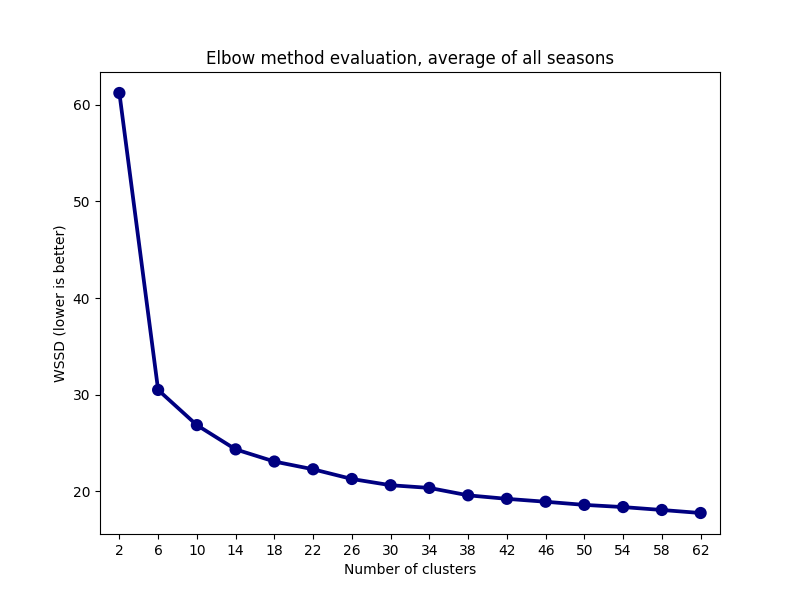

In [64]:
plot_clustering_results(
    clustering_results_dict["avg"], 
    k_range=K_RANGE, 
    plot_title="Elbow method evaluation, average of all seasons",
)

## Dataset composition

### Compute distance between player and centroid of its cluster

In [65]:
compute_distance_from_centroid_UDF = udf(
    lambda player, centroid: float(
        Vectors.squared_distance(
            player, centroid
        )
    ), FloatType()
)

In [66]:
if os.path.isdir(CLUSTERING_DF_PATH):
    print("clustering data found on disk, loading...")
    pre_processed_df = spark.read.parquet(CLUSTERING_DF_PATH)

clustering data found on disk, loading...


In [67]:
for k in K_RANGE:
    pre_processed_df = pre_processed_df.withColumn(
        "distance_from_centroid" + "_k_" + k,
        compute_distance_from_centroid_UDF(
            col("clustering_features_vec_min_max"),
            col("centroid" + "_k_" + k)
        )
    )
        

### From players to teams

In [68]:
teams_df = pre_processed_df.groupBy(
    ["season", "club_name", "macro_role"]
).agg(
    {
        "distance_from_centroid" + "_k_" + str(k): "avg" for k in K_RANGE 
    }
)

for k in K_RANGE:
    teams_df = teams_df.withColumnRenamed(
        "avg(distance_from_centroid" + "_k_" + str(k) + ")",
        "avg_distance_from_centroid" + "_k_" + str(k)
    )

In [69]:
def generate_subquery(macro_role, k):
    return f"""(
        case
            when macro_role='{macro_role}' then avg_distance_from_centroid_k_{k} 
        else NULL
        end
    ) as avg_dist_macro_role_{int(macro_role)}_k_{k}
    """

In [70]:
teams_df.createOrReplaceTempView("t")

temp = dict()

for k in K_RANGE:
    temp[k] = (
        spark.sql(
            f"""
                select season, club_name, {generate_subquery(0.0, k)}, {generate_subquery(1.0, k)}, {generate_subquery(2.0, k)}, {generate_subquery(3.0, k)}, {generate_subquery(4.0, k)}, {generate_subquery(5.0, k)}, {generate_subquery(6.0, k)}, {generate_subquery(7.0, k)}
                from t
            """
        )
        .groupBy("season", "club_name")
        .agg(
            # TODO use for loop as in second cell of "from players to teams"
            sum(f"avg_dist_macro_role_0_k_{k}").alias(f"avg_dist_macro_role_0_k_{k}"),
            sum(f"avg_dist_macro_role_1_k_{k}").alias(f"avg_dist_macro_role_1_k_{k}"),
            sum(f"avg_dist_macro_role_2_k_{k}").alias(f"avg_dist_macro_role_2_k_{k}"),
            sum(f"avg_dist_macro_role_3_k_{k}").alias(f"avg_dist_macro_role_3_k_{k}"),
            sum(f"avg_dist_macro_role_4_k_{k}").alias(f"avg_dist_macro_role_4_k_{k}"),
            sum(f"avg_dist_macro_role_5_k_{k}").alias(f"avg_dist_macro_role_5_k_{k}"),
            sum(f"avg_dist_macro_role_6_k_{k}").alias(f"avg_dist_macro_role_6_k_{k}"),
            sum(f"avg_dist_macro_role_7_k_{k}").alias(f"avg_dist_macro_role_7_k_{k}"),
        )
    )

In [106]:
# NOTE executing this cell n times, w/o restoring teams_df --> 
# n copies of avg_dist_macro_role_[0:7]_k_[2, 6]

teams_df = temp[K_RANGE[0]]

for i in range(1, len(K_RANGE)):
    teams_df = teams_df.join(
        temp[K_RANGE[i]],
        on=["season", "club_name"]
    )

In [107]:
avg_distances_dict = dict()
avg_distances_vec_dict = dict()

for k in K_RANGE:
    
    avg_distances_dict[k] = [
        f"avg_dist_macro_role_{i}_k_{k}" for i in range(0, NUM_MACRO_ROLES)
    ]

    avg_distances_vec_dict[k] = f"avg_dist_vec_k_{k}"

In [108]:
global_max = teams_df.toPandas()[
    [ x for x in avg_distances_dict.values() for x in x ]
].to_numpy().reshape(-1).max()

/home/linuxbrew/.linuxbrew/Cellar/python@3.9/3.9.7_1/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:202: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[column_name] = series


In [109]:
teams_df = teams_df.fillna(global_max * 1.5)    

In [110]:
for k in K_RANGE:
    assembler = VectorAssembler(
        inputCols=avg_distances_dict[k], outputCol=avg_distances_vec_dict[k]
    )

    teams_df = assembler.transform(teams_df)

## Visualizations

In [ ]:
pre_processed_df, pca_model = perform_pca(
    df=pre_processed_df,
    num_components=2,
    input_col="clustering_features_vec_min_max",
    output_col="clustering_features_vec_min_max_pcs"
)

In [ ]:
pdf = feature_vec_to_cols(
    pre_processed_df.toPandas(),
    "clustering_features_vec_min_max_pcs",
    ["clustering_features_vec_min_max_pc_0", "clustering_features_vec_min_max_pc_1"]
)

In [ ]:
for s in seasons:
    scatter_plot(
        x = pdf[pdf["season"] == s]["clustering_features_vec_min_max_pc_0"],
        y = pdf[pdf["season"] == s]["clustering_features_vec_min_max_pc_1"],
        x_label="Clustering Features Principal Component 0",
        y_label="Clustering Features Principal Component 1",
        title=f"Clustering result for season {s}",
        c=pdf[pdf["season"] == s]["cluster_id_k_6"],
        c_map=plt.cm.get_cmap("tab10"),
        figsize=(12,8),
    )

## Learning from clustering

In [111]:
df = df.join(
    teams_df,
    on=["club_name", "season"]
)

In [112]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=random_seed)

FEATURES_COL = "avg_dist_vec_k_6"

### Regression

In [113]:
regression_evaluator_cv.setLabelCol(REGRESSION_LABEL_COL)

RegressionEvaluator_e3de962ccab0

#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

PREDICTION_COL = "attempt_3_regression_linear_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression"]
):
    print("Linear Regression model NOT found in disk, training...")
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = LinearRegression()

    linear_regression_param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
        # .addGrid(estimator.solver, ["auto", "normal"])
        # .addGrid(estimator.fitIntercept, [True, False])
        # .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=linear_regression_param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Linear Regression model found in disk, loading...")
    model = LinearRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression"]
):
    print("Evaluating Linear Regression model trained in previous cell...")
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/regression/linear_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/regression/linear_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression"]
):
    print("Saving Linear Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/regression/linear_regression"
    )

#### Linear regression (multiple k)

In [120]:
model_evals_dict = dict()
cross_validated_models_dict = dict()

In [121]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

for k in K_RANGE:

    PREDICTION_COL = f"attempt_3_regression_linear_regression_multiple_k_{k}_predictions"

    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression multiple k"][k]
    ):
        print(f"Linear Regression multiple k with k={k} model NOT found in disk, training...")
        regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
        
        estimator = LinearRegression()

        param_grid = (
            ParamGridBuilder()
            .addGrid(estimator.featuresCol, [f"avg_dist_vec_k_{k}"])
            .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
            .addGrid(estimator.predictionCol, [PREDICTION_COL])
            # .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
            # .addGrid(estimator.solver, ["auto", "normal"])
            # .addGrid(estimator.fitIntercept, [True, False])
            # .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
        )

        cross_validated_models_dict[k] = learn_best_model(
            estimator=estimator,
            param_grid=param_grid,
            evaluator_cv=regression_evaluator_cv
        )
    else:
        print("Linear Regression multiple k with k={k} model found in disk, loading...")
        model = LinearRegressionModel.load(
            TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression multiple k"][k]
        )

Linear Regression multiple k with k=2 model NOT found in disk, training...


Linear Regression multiple k with k=6 model NOT found in disk, training...


Linear Regression multiple k with k=10 model NOT found in disk, training...


Linear Regression multiple k with k=14 model NOT found in disk, training...


Linear Regression multiple k with k=18 model NOT found in disk, training...


Linear Regression multiple k with k=22 model NOT found in disk, training...


Linear Regression multiple k with k=26 model NOT found in disk, training...


Linear Regression multiple k with k=30 model NOT found in disk, training...


Linear Regression multiple k with k=34 model NOT found in disk, training...


Linear Regression multiple k with k=38 model NOT found in disk, training...


Linear Regression multiple k with k=42 model NOT found in disk, training...


Linear Regression multiple k with k=46 model NOT found in disk, training...


Linear Regression multiple k with k=50 model NOT found in disk, training...


Linear Regression multiple k with k=54 model NOT found in disk, training...


Linear Regression multiple k with k=58 model NOT found in disk, training...


Linear Regression multiple k with k=62 model NOT found in disk, training...


In [127]:
for k in K_RANGE:
    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression multiple k"][k]
    ):
        print(
            f"Evaluating Linear Regression multiple k with k={k} model trained in previous cell...")
        
        PREDICTION_COL = f"attempt_3_regression_linear_regression_multiple_k_{k}_predictions"
        evaluate_learning_models(
            best_model=cross_validated_models_dict[k].bestModel,
            evaluators=get_evaluators(
                cross_validated_models_dict[k].bestModel, 
                label_col=REGRESSION_LABEL_COL, 
                prediction_col=PREDICTION_COL, 
                evaluation_metrics=REGRESSION_EVALUATION_METRICS
            ),
            save_training_result_path=f"./evaluation_results/attempt_3/regression/linear_regression_multiple_k/linear_regression_multiple_k_{k}.json"
        )
    else:
        print("Printing evaluation loaded from disk...")
        model_evals_dict[k] = print_model_evaluation(
            model_evaluation_path=f"./evaluation_results/attempt_3/regression/linear_regression_multiple_k/linear_regression_multiple_k_{k}.json"
        )

Printing evaluation loaded from disk...
{'test_set_evaluation': {'mae': 9.686458216867836,
                         'mse': 146.24219237203613,
                         'r2': 0.49718458635830887,
                         'rmse': 12.093063812452002,
                         'var': 121.00644802456885},
 'train_set_evaluation': {'explainedVariance': 115.69413048268765,
                          'meanAbsoluteError': 9.880533280404322,
                          'meanSquaredError': 155.0226715042796,
                          'r2': 0.42736220889708476,
                          'r2adj': 0.4269703267474848,
                          'rootMeanSquaredError': 12.450810074219252}}
Printing evaluation loaded from disk...
{'test_set_evaluation': {'mae': 9.64952885703148,
                         'mse': 145.67561482968352,
                         'r2': 0.4991326146030809,
                         'rmse': 12.069615355498431,
                         'var': 120.88020247670147},
 'train_set_evaluation'

In [130]:
evals_dict_pretty = {
    k : v["test_set_evaluation"]["r2"] for (k, v) in zip(model_evals_dict.keys(), model_evals_dict.values())
}

In [126]:
for k in K_RANGE:    
    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Linear Regression multiple k"][k]
    ):
        print(
            f"Saving Linear Regression multiple k with k={k} model on disk..."
        )
        cross_validated_models_dict[k].bestModel.save(
            f"./trained_models/attempt_3/regression/linear_regression_multiple_k/{k}_clusters"
        )

#### Prediction Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import DecisionTreeRegressionModel

PREDICTION_COL = "attempt_3_regression_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Prediction Tree"]
):
    print("Prediction Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Decision Tree model found in disk, loading...")
    model = DecisionTreeRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Prediction Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Prediction Tree"]
):
    print(
        "Evaluating Prediction Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/regression/prediction_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/regression/prediction_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Prediction Tree"]
):
    print("Saving Decision Tree Regressor model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/regression/prediction_tree"
    )

#### Gradient Boosted Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel

PREDICTION_COL = "attempt_3_regression_gradient_boosted_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Gradient Boosted Tree"]
):
    print("Regression Gradient Boosted Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = GBTRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [2, 5, 10])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Gradient Boosted Tree model found in disk, loading...")
    model = GBTRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Gradient Boosted Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Gradient Boosted Tree"]
):
    print(
        "Evaluating Gradient Boosted Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/regression/gradient_boosted_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/regression/gradient_boosted_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Gradient Boosted Tree"]
):
    print("Saving Gradient Boosted Tree Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/regression/gradient_boosted_tree"
    )

#### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressionModel

PREDICTION_COL = "attempt_3_regression_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Random Forest"]
):
    print("Regression Random Forest model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        # .addGrid(estimator.numTrees, [20, 40])
        # .addGrid(
        #     estimator.featureSubsetStrategy, 
        #     ["auto", "onethird", "all", "log2"]
        # )
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Random Forest model found in disk, loading...")
    model = RandomForestRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/regression/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/regression/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Regression"]["Random Forest"]
):
    print("Saving Random Forest Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/regression/random_forest"
    )

### Classification

In [ ]:
classification_evaluator_cv.setLabelCol(CLASSIFICATION_LABEL_COL)

In [ ]:
train_df, test_df = df.randomSplit([0.9, 0.1], seed=random_seed)

#### SVM Classifier

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LinearSVC

PREDICTION_COL = "attempt_3_classification_svm_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["SVM"]
):
    print("SVM Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LinearSVC(
            featuresCol=FEATURES_COL[0],
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL[0],
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("SVM Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["SVM"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["SVM"]
):
    print(
        "Evaluating SVM Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/classification/svm.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/classification/svm.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["SVM"]
):
    print("Saving SVM Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/classification/svm"
    )

#### Logistic Regression

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LogisticRegression

PREDICTION_COL = "attempt_3_classification_logistic_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Logistic Regression"]
):
    print("Logistic Regression Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LogisticRegression(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Logistic Regression Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Logistic Regression"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Logistic Regression"]
):
    print(
        "Evaluating Logistic Regression Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/classification/logistic_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/classification/logistic_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Logistic Regression"]
):
    print("Saving Logistic Regression Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/classification/logistic_regression"
    )

#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel

PREDICTION_COL = "attempt_3_classification_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Decision Tree"]
):
    print("Classification Decision Tree model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Decision Tree model found in disk, loading...")
    model = DecisionTreeClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Decision Tree"]
    )
    evaluators = get_evaluators(
        model, 
        label_col=CLASSIFICATION_LABEL_COL, 
        prediction_col=PREDICTION_COL, 
        evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Decision Tree"]
):
    print(
        "Evaluating Decision Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/classification/decision_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/classification/decision_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Decision Tree"]
):
    print("Saving Decision Tree model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/classification/decision_tree"
    )

#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

PREDICTION_COL = "attempt_3_classification_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Random Forest"]
):
    print("Classification Random Forest model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        # .addGrid(estimator.numTrees, [20, 40])
        # .addGrid(estimator.featureSubsetStrategy, ["auto", "onethird", "all", "log2"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Random Forest model found in disk, loading...")
    model = RandomForestClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/classification/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/classification/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["Random Forest"]
):
    print("Saving Random Forest Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/classification/random_forest"
    )

#### MLP

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

PREDICTION_COL = "attempt_3_classification_mlp_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["MLP"]
):
    print("Classification MLP model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = MultilayerPerceptronClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.layers, [[NUM_MACRO_ROLES, NUM_MACRO_PLACES]])
        .addGrid(estimator.solver, ["gd"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification MLP model found in disk, loading...")
    model = MultilayerPerceptronClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["MLP"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["MLP"]
):
    print(
        "Evaluating MLP model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_3/classification/mlp.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_3/classification/mlp.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 3"]["Classification"]["MLP"]
):
    print("Saving MLP Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_3/classification/mlp"
    )

## Clustering-learning cross evaluation

Classic left-right plot, with:
Left Y --> elbow result
Right Y --> accuracy
X axis --> # clusters

In [159]:
# pprint.pprint(model_evals_dict)
# print(clustering_results_dict["avg"])

x = list(model_evals_dict.keys())
wssd_k = [
    x["wssd_k"] for x in clustering_results_dict["avg"].values()
]
r2 = [
    x["test_set_evaluation"]["r2"] for x in model_evals_dict.values()
]

print(x)
print(wssd_k)
print(r2)



['2', '6', '10', '14', '18', '22', '26', '30', '34', '38', '42', '46', '50', '54', '58', '62']
[61.211918866863016, 30.48815737570571, 26.84619404349526, 24.337701642222047, 23.07920189778952, 22.277014896829712, 21.273754729233218, 20.628445766620192, 20.35061871727908, 19.582170364745323, 19.21964560259489, 18.918866317113054, 18.594175700333487, 18.367258226195933, 18.067158929449814, 17.754057793631976]
[0.49718458635830887, 0.4991326146030809, 0.4983351918444149, 0.49848875748021015, 0.49855272482411206, 0.4984628268359963, 0.49835515063218805, 0.4983834420447294, 0.49853869240911597, 0.498271996268292, 0.4984679209366708, 0.49829891930142534, 0.4981861340050272, 0.4982922358854991, 0.49826746505093966, 0.49817159566544356]


In [160]:
plot_df_temp = pd.DataFrame([x, wssd_k, r2]).transpose()
plot_df_temp.columns = ["x", "wssd_k", "r2"]

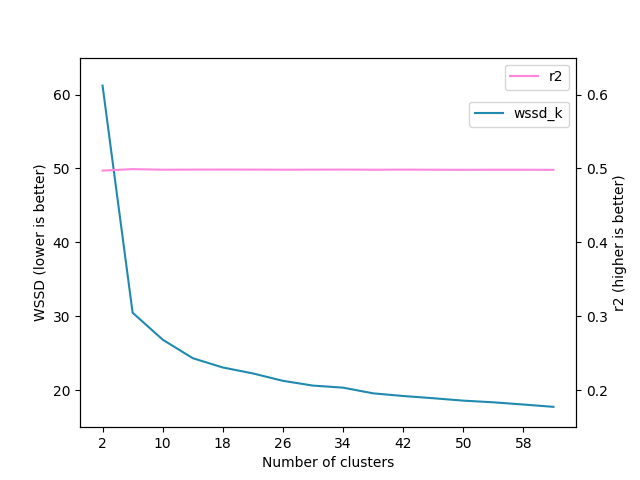

Text(0.5, 1.0, 'Elbow method vs. r2')

In [178]:
ax = plot_df_temp.plot(
    x="x", 
    y="wssd_k", 
    color="#208AAE"
)
ax.set_xlabel("Number of clusters")
ax.set_ylabel("WSSD (lower is better)")
ax.set_ylim(15, 65)
ax.legend(bbox_to_anchor=(1,0.9))

ax2 = ax.twinx()

plot_df_temp.plot(
    x="x", 
    y="r2", 
    ax=ax2, 
    color="#FF88DC",
)
ax2.set_ylabel("r2 (higher is better)")
ax2.set_ylim(0.15, 0.65)
ax2.legend(bbox_to_anchor=(1,1))


# ax.figure.legend()
plt.show()
plt.title("Elbow method vs. r2")

# Attempt 4: thinking "Deep", shallow injecting some priors

In [ ]:
rp_df = df

In [ ]:
MAX_PLACE = 21

## Computing the prior (RP coefficient)

In [ ]:
rp_df.select("season", "club_name", "place").createOrReplaceTempView("t")

In [ ]:
rp_df = spark.sql(
    f"""
    select t.season, t.club_name,
        avg(
            (
                select sub.place
                where sub.season < t.season and sub.club_name == t.club_name
            )
        ) as rp_coeff
    from t, t as sub
    group by t.season, t.club_name
    order by t.season desc
    """
).fillna(MAX_PLACE)

In [ ]:
rp_df = rp_df.withColumn("rp_coeff", MAX_PLACE - col("rp_coeff"))

In [ ]:
add_normalize_by_rp_UDF = udf(
    lambda points, rp, tradeoff: points + tradeoff * rp, DoubleType()
)

In [ ]:
rp_df = rp_df.join(
    df, on=["club_name", "season"]
)

In [ ]:
from pyspark.ml.feature import VectorAssembler

RP_NORMALIZED_COLS = [
    f"avg(overall)_rp_normalized_tradeoff_{tradeoff}".replace(
        ".", "-"
    ) for tradeoff in ADD_RP_TRADEOFF
]

for tradeoff, col_name in zip(ADD_RP_TRADEOFF, RP_NORMALIZED_COLS):
    rp_df = rp_df.withColumn(
        col_name, add_normalize_by_rp_UDF(
            # col("avg(overall)"), col("rp_coeff"), lit(tradeoff)
            col("points"), col("rp_coeff"), lit(tradeoff)
        )
    )

    assembler = VectorAssembler(
        inputCols=[col_name], 
        outputCol=col_name + "_vec"
    )

    rp_df = assembler.transform(rp_df)

In [ ]:
rp_df.select(rp_norm_col, "avg(overall)").show()

In [ ]:
FEATURES_COL = [
    rp_normalized_col + "_vec" for rp_normalized_col in RP_NORMALIZED_COLS
]

## Visualizations

### Feature-target correlation

In [ ]:
pdf = rp_df.toPandas()

for rp_norm_col in RP_NORMALIZED_COLS:
    plot_feature_target_relation(
        pdf, ["avg(overall)"], rp_norm_col, color="pink"
    )

## Learning

In [ ]:
train_df, test_df = rp_df.randomSplit([0.9, 0.1], seed=random_seed)

### Regression

In [ ]:
regression_evaluator_cv.setLabelCol(REGRESSION_LABEL_COL)

#### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

PREDICTION_COL = "attempt_4_regression_linear_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression"]
):
    print("Linear Regression model NOT found in disk, training...")
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = LinearRegression()

    linear_regression_param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
        # .addGrid(estimator.solver, ["auto", "normal"])
        # .addGrid(estimator.fitIntercept, [True, False])
        # .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=linear_regression_param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Linear Regression model found in disk, loading...")
    model = LinearRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression"]
):
    print("Evaluating Linear Regression model trained in previous cell...")
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/regression/linear_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/regression/linear_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression"]
):
    print("Saving Linear Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/regression/linear_regression"
    )

#### Linear Regression multiple rp tradeoffs

In [ ]:
cross_validated_models_dict = dict()

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel

for tradeoff, col_name in zip(ADD_RP_TRADEOFF, FEATURES_COL):
    PREDICTION_COL = "attempt_4_regression_linear_regression_multiple_tradeoffs_{tradeoff}_predictions"

    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression multiple tradeoffs"][tradeoff]
    ):
        print(
            f"Linear Regression multiple tradeoffs with tradeoff={tradeoff} model NOT found in disk, training..."
        )
        regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
        
        estimator = LinearRegression()

        linear_regression_param_grid = (
            ParamGridBuilder()
            .addGrid(estimator.featuresCol, [col_name])
            .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
            .addGrid(estimator.predictionCol, [PREDICTION_COL])
            # .addGrid(estimator.regParam, [0.0, 0.001, 0.01, 0.1, 0.5, 1])
            # .addGrid(estimator.solver, ["auto", "normal"])
            # .addGrid(estimator.fitIntercept, [True, False])
            # .addGrid(estimator.elasticNetParam, [0.0, 0.5, 1.0])
            .build()
        )

        cross_validated_models_dict[tradeoff] = learn_best_model(
            estimator=estimator,
            param_grid=linear_regression_param_grid,
            evaluator_cv=regression_evaluator_cv
        )
    else:
        print(f"Linear Regression multiple tradeoffs with tradeoff={tradeoff} model found in disk, loading...")
        model = LinearRegressionModel.load(
            TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression multiple tradeoffs"][tradeoff]
        )

In [ ]:
model_evals_dict = dict()

In [ ]:
for tradeoff, col_name in zip(ADD_RP_TRADEOFF, FEATURES_COL):
    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression multiple tradeoffs"][tradeoff]
    ):
        print(
            f"Evaluating Linear Regression multiple tradeoffs with tradeoff={tradeoff} model trained in previous cell...")
        evaluate_learning_models(
            best_model=cross_validated_models_dict[tradeoff].bestModel,
            evaluators=get_evaluators(
                cross_validated_models_dict[tradeoff].bestModel, 
                label_col=REGRESSION_LABEL_COL, 
                prediction_col=PREDICTION_COL, 
                evaluation_metrics=REGRESSION_EVALUATION_METRICS
            ),
            save_training_result_path=f"./evaluation_results/attempt_4/regression/linear_regression_multiple_tradeoffs/tradeoff_{tradeoff}.json"
        )
    else:
        print("Printing evaluation loaded from disk...")
        model_evals_dict[tradeoff] = print_model_evaluation(
            model_evaluation_path=f"./evaluation_results/attempt_4/regression/linear_regression_multiple_tradeoffs/tradeoff_{tradeoff}.json"
        )

In [ ]:
evals_dict_pretty = {
    k : v["train_set_evaluation"]["r2"] for (k, v) in zip(model_evals_dict.keys(), model_evals_dict.values())
}
evals_dict_pretty

In [ ]:
for tradeoff, col_name in zip(ADD_RP_TRADEOFF, FEATURES_COL):
    if not model_exists(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Linear Regression multiple tradeoffs"][tradeoff]
    ):
        print(
            f"Saving Linear Regression multiple tradeoffs with tradeoff={tradeoff} model on disk..."
        )
        cross_validated_models_dict[tradeoff].bestModel.save(
            f"./trained_models/attempt_4/regression/linear_regression_multiple_tradeoffs/tradeoff_{tradeoff}"
        )

#### Prediction Tree

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import DecisionTreeRegressionModel

PREDICTION_COL = "attempt_4_regression_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Prediction Tree"]
):
    print("Prediction Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Decision Tree model found in disk, loading...")
    model = DecisionTreeRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Prediction Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Prediction Tree"]
):
    print(
        "Evaluating Prediction Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/regression/prediction_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/regression/prediction_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Prediction Tree"]
):
    print("Saving Decision Tree Regressor model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/regression/prediction_tree"
    )

#### Gradient Boosted Tree Regression

In [ ]:
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.regression import GBTRegressionModel

PREDICTION_COL = "attempt_4_regression_gradient_boosted_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Gradient Boosted Tree"]
):
    print("Regression Gradient Boosted Tree model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = GBTRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [2, 5, 10])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Gradient Boosted Tree model found in disk, loading...")
    model = GBTRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Gradient Boosted Tree"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Gradient Boosted Tree"]
):
    print(
        "Evaluating Gradient Boosted Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/regression/gradient_boosted_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/regression/gradient_boosted_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Gradient Boosted Tree"]
):
    print("Saving Gradient Boosted Tree Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/regression/gradient_boosted_tree"
    )

#### Random Forest Regression

In [ ]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import RandomForestRegressionModel

PREDICTION_COL = "attempt_4_regression_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Random Forest"]
):
    print("Regression Random Forest model NOT found in disk, training...")
    
    regression_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestRegressor()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [REGRESSION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        # .addGrid(estimator.numTrees, [20, 40])
        # .addGrid(
        #     estimator.featureSubsetStrategy, 
        #     ["auto", "onethird", "all", "log2"]
        # )
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=regression_evaluator_cv
    )
else:
    print("Regression Random Forest model found in disk, loading...")
    model = RandomForestRegressionModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=REGRESSION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=REGRESSION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/regression/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/regression/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Regression"]["Random Forest"]
):
    print("Saving Random Forest Regression model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/regression/random_forest"
    )

### Classification

In [ ]:
classification_evaluator_cv.setLabelCol(CLASSIFICATION_LABEL_COL)

#### SVM Classifier

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LinearSVC

PREDICTION_COL = "attempt_4_classification_svm_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["SVM"]
):
    print("SVM Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LinearSVC(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL[0],
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("SVM Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["SVM"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["SVM"]
):
    print(
        "Evaluating SVM Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/classification/svm.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/classification/svm.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["SVM"]
):
    print("Saving SVM Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/classification/svm"
    )

#### Logistic Regression

In [ ]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import OneVsRestModel
from pyspark.ml.classification import LogisticRegression

PREDICTION_COL = "attempt_4_classification_logistic_regression_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Logistic Regression"]
):
    print("Logistic Regression Classification model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = OneVsRest(
        classifier=LogisticRegression(
            featuresCol=FEATURES_COL,
            labelCol=CLASSIFICATION_LABEL_COL,
            predictionCol=PREDICTION_COL,
        ),
        featuresCol=FEATURES_COL,
        labelCol=CLASSIFICATION_LABEL_COL,
        predictionCol=PREDICTION_COL
    )

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, [FEATURES_COL])
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Logistic Regression Classification model found in disk, loading...")
    model = OneVsRestModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Logistic Regression"]
    )


In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Logistic Regression"]
):
    print(
        "Evaluating Logistic Regression Classifier model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/classification/logistic_regression.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/classification/logistic_regression.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Logistic Regression"]
):
    print("Saving Logistic Regression Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/classification/logistic_regression"
    )

#### Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import DecisionTreeClassificationModel

PREDICTION_COL = "attempt_4_classification_decision_tree_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Decision Tree"]
):
    print("Classification Decision Tree model NOT found in disk, training...")
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = DecisionTreeClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [16, 32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Decision Tree model found in disk, loading...")
    model = DecisionTreeClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Decision Tree"]
    )
    evaluators = get_evaluators(
        model, 
        label_col=CLASSIFICATION_LABEL_COL, 
        prediction_col=PREDICTION_COL, 
        evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Decision Tree"]
):
    print(
        "Evaluating Decision Tree model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/classification/decision_tree.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/classification/decision_tree.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Decision Tree"]
):
    print("Saving Decision Tree model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/classification/decision_tree"
    )

#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassificationModel

PREDICTION_COL = "attempt_4_classification_random_forest_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Random Forest"]
):
    print("Classification Random Forest model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = RandomForestClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        # .addGrid(estimator.maxDepth, [5, 24])
        # .addGrid(estimator.maxBins, [32, 64])
        # .addGrid(estimator.minInfoGain, [0, 0.1])
        # .addGrid(estimator.subsamplingRate, [0.5, 1])
        # .addGrid(estimator.lossType, ["squared", "absolute"])
        # .addGrid(estimator.numTrees, [20, 40])
        # .addGrid(estimator.featureSubsetStrategy, ["auto", "onethird", "all", "log2"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification Random Forest model found in disk, loading...")
    model = RandomForestClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Random Forest"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Random Forest"]
):
    print(
        "Evaluating Random Forest model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/classification/random_forest.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/classification/random_forest.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["Random Forest"]
):
    print("Saving Random Forest Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/classification/random_forest"
    )

#### MLP

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.classification import MultilayerPerceptronClassificationModel

PREDICTION_COL = "attempt_4_classification_mlp_predictions"

if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["MLP"]
):
    print("Classification MLP model NOT found in disk, training...")
    
    classification_evaluator_cv.setPredictionCol(PREDICTION_COL)
    
    estimator = MultilayerPerceptronClassifier()

    param_grid = (
        ParamGridBuilder()
        .addGrid(estimator.featuresCol, FEATURES_COL)
        .addGrid(estimator.labelCol, [CLASSIFICATION_LABEL_COL])
        .addGrid(estimator.predictionCol, [PREDICTION_COL])
        .addGrid(estimator.layers, [[1, NUM_MACRO_PLACES]])
        .addGrid(estimator.solver, ["gd"])
        .build()
    )

    cross_validated_models = learn_best_model(
        estimator=estimator,
        param_grid=param_grid,
        evaluator_cv=classification_evaluator_cv
    )
else:
    print("Classification MLP model found in disk, loading...")
    model = MultilayerPerceptronClassificationModel.load(
        TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["MLP"]
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["MLP"]
):
    print(
        "Evaluating MLP model trained in previous cell..."
    )
    evaluate_learning_models(
        best_model=cross_validated_models.bestModel,
        evaluators=get_evaluators(
            cross_validated_models.bestModel, 
            label_col=CLASSIFICATION_LABEL_COL, 
            prediction_col=PREDICTION_COL, 
            evaluation_metrics=CLASSIFICATION_EVALUATION_METRICS
        ),
        save_training_result_path="./evaluation_results/attempt_4/classification/mlp.json"
    )
else:
    print("Printing evaluation loaded from disk...")
    print_model_evaluation(
        model_evaluation_path="./evaluation_results/attempt_4/classification/mlp.json"
    )

In [ ]:
if not model_exists(
    TRAINED_MODELS_DIRS["Attempt 4"]["Classification"]["MLP"]
):
    print("Saving MLP Classification model on disk...")
    cross_validated_models.bestModel.save(
        "./trained_models/attempt_4/classification/mlp"
    )

## RP impact

plot showing that the more the weight of the RP coefficient is increased, the more the accuracy ofc goes up